# Imports

In [77]:
import re
from os import makedirs, system
from pathlib import Path
from timeit import timeit
import matplotlib as mpl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from src import networks as nws
from src import pykwrapper as pkw
from pykinetic.writers.python import Batch as Writer
from pykinetic.classes import ConvergenceParameters, SimulationParameters, Compound
import seaborn as sns
from scipy import optimize
from scipy.stats import pearsonr

pd.options.display.max_columns = 100


params = {"font.family": "Arial", 'mathtext.default': 'regular'}      
plt.rc('font', size=8)
plt.rcParams.update(params)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
nice_structure_names = {
    "00-lpdoh2": "[LPd(OH)$_2$]",
    "01-rxt": "RXT",
    "02-ts-rxt-c1": "RXT-C1",
    "03-c1": "C1",
    "04-ts-c1-c2": "C1-C2",
    "05-c2": "C2",
    "06-c2-h2o": "C2 + H$_2$O", 
    "07-ts-c2-c3": "C2-C3",
    "08-c3-boh3": "C3 + B(OH)$_3$", 
    "09-c3": "C3",
    "10-ts-c3-c4": "C3-C4",
    "11-c4": "C4",
    "12-ts-rxt-t1": "RXT-T1",
    "13-t1": "T1",
    "14-ts-t1-t2": "T1-T2",
    "15-t2": "T2",
    "16-t2-h2o": "T2 + H$_2$O", 
    "18-t3-boh3": "T3 + B(OH)$_3$", 
    "17-ts-t2-t3": "T2-T3",
    "19-t3": "T3",
    "20-ts-t3-t4": "T3-T4",
    "21-t4": "T4",
    "22-c5": "C5",
    "23-ts-c5-c6": "C5-C6",
    "24-t5": "T5",
    "25-ts-t5-t6": "T5-T6",
    "26-ts-t2-xa": "T2-XA",
    "27-xa": "XA",
    "28-ts-xa-t3": "XA-T3",
    "29-ts-t2-xb": "T2-XB",
    "30-xb": "XB",
    "31-ts-t3-xb": "T3-XB",
    "32-ts-rxt-ya": "RXT-YA",
    "33-ya": "YA",
    "34-ts-ya-c1": "YA-C1",
    "35-ts-rxt-yb": "RXT-YB",
    "36-yb": "YB",
    "37-ts-yb-c1": "YB-C1",
    "38-t2-lig": "T2 + L",
    "39-ts-t2-t2p": "T2-T2P",
    "40-t2p-boh3": "T2P + B(OH)$_3$",
    "41-t2p": "T2P",
    "pre-catalyst": "[Pd(OH)$_2$]",
    "ligand": "L",
    "naphh-t": "NaphH-T",
    'naphboh2': 'NaphB(OH)$_2$',
    'h2o': "H$_2$O",
    'boh3': "B(OH)$_3$",
}

proper_names_dict = {'3r-adjohnphos': "AdJohnPhos",
 '3s-adbrettphos': "AdBrettPhos",
 '3k-brettphos': "BrettPhos",
 '3d-cyjohnphos': "CyJohnPhos",
 '3e-cymephos': "CyMePhos",
 '3f-davephos': "DavePhos",
 '3a-iprjohnphos': "(i-Pr)JohnPhos",
 '3q-me4tbuxphos': "Me$_4$tBuXPhos",
 '2k-pad3': "P(Ad)$_3$",
 '2f-pcpt3': "P(Cpt)$_3$",
 '2h-pcy2tbu': "P(Cy)$_2$(t-Bu)",
 '2g-pcy3': "P(Cy)$_3$",
 '3b-phjohnphos': "PhJohnPhos",
 '3c-phdavephos': "PhDavePhos",
 '2e-pipr3': "P(i-Pr)$_3$",
 '2d-potol3': "P(o-tol)$_3$",
 '2c-pph3': "P(Ph)$_3$",
 '2i-ptbu2cy': "P(t-Bu)$_2$(Cy)",
 '2j-ptbu3': "P(t-Bu)$_3$",
 '3i-ruphos': "RuPhos",
 '3g-sphos': "SPhos",
 '3l-tbujohnphos': "JohnPhos",
 '3p-tbubrettphos': "tBuBrettPhos",
 '3n-tbudavephos': "tBuDavePhos",
 '3m-tbumephos': "tBuMePhos",
 '3o-tbuxphos': "tBuXPhos",
 '3j-xphos': "XPhos",
 '3h-ssphos': "sSPhos",    
 '9c-etjohnphos': "EtJohnPhos",
 '9d-mejohnphos': "MeJohnPhos",
 '9a-cbujohnphos': 'CbuJohnPhos',
 '9b-cptjohnphos': 'CptJohnPhos',
 '9e-pcbu3': 'P(Cbu)$_3$',     
 '9f-pcpr3': 'P(Cpr)$_3$',
 '9h-pme3': 'P(Me)$_3$',
 '9g-pet3': 'P(Et)$_3$',
}

In [94]:
DEBUG: bool = True  # Debug utilities

MK_T: float = 333.15               # Temperature (K)

kb: float = 1.38064852E-023     # Boltzmann Constant (kg·m2·s-2·K-1)
Na: float = 6.02214076E+023     # Avogadro's Number (mol-1)
h: float = 6.62607004E-034      # Plank Constant (m2·kg·s-1)
R: float = 8.31445985           # Ideal Gas Constant (kg⋅m2⋅s−2⋅K−1⋅mol−1)


def calc_kd (
    mu: float                   # Viscosity Constant (kg·m-1·s-1)
    , T: float=MK_T             # Temperature (K)
    , kb: float=kb              # Boltzmann Constant (kg·m2·s-2·K-1)
    , Na: float=Na              # Avogadro's Number (mol-1)
) -> float:         
    out: float = (kb * 8 * T)  # kg·m2·s-2·K-1 · K             -> kg·m2·s-2 
    out /= (3 * mu)            # kg·m2·s-2     / kg·m-1·s-1    -> m3·s-1
    out *= Na                  # m3·s-1        · mol-1         -> m3·mol-1·s-1
    return out                 # Diffusion constant kd (m3·mol-1·s-1)

def k2ae (
    kd: float                  # Diffusion constant kd (m3·mol-1·s-1)
    , T: float=MK_T            # Temperature (K)
    , kb: float=kb             # Boltzmann Constant (kg·m2·s-2·K-1)
    , R: float=R               # Ideal Gas Constant (kg⋅m2⋅s−2⋅K−1⋅mol−1)
    , h: float=h               # Planck Constant (m2·kg·s-1)
) -> float:
    ae: float = kb*(T)/h       # kg·m2·s-2·K-1 · K / m2·kg·s-1 -> s-1
    ae = kd/ae                 # m3·mol-1·s-1 / s-1            -> m3·mol-1
    ae = np.log(ae)            # m3·mol-1 · (c⊖)1–m (mol·m-3)  -> 1
    ae *= -R*(T)               # 1 · kg⋅m2⋅s−2⋅K−1⋅mol−1 · K   -> kg⋅m2⋅s−2⋅K−1⋅mol−1 
    return (ae)                # Ae (kg⋅m2⋅s−2⋅mol−1)[J·mol-1] -> J/mol
    
def joule2hartree (
    J: float
) -> float: 
    return J / 2625.5 / 1000

calc_ae = lambda x: joule2hartree(k2ae(calc_kd(x)))

def get_mk_file(D_NAME, mk_params, concentrations_dict):
    D_PATH: Path = Path("microkinetics")                    # Data directory
    R_PATH: Path = Path("microkinetics")                 # Results directory
    D_NAME: str = D_NAME                           # Name of the dataset

    DS_DIR: Path = D_PATH/D_NAME                   # Dataset location
    RS_DIR: Path = R_PATH/D_NAME                   # Results location

    GRAPH_FILE: Path = RS_DIR/"graph.svg"          # Graph file path
    MODEL_FILE: Path = RS_DIR/f"{D_NAME}-model.py"           # MK model file path
    RESULTS_FILE: Path = RS_DIR/f"{D_NAME}-results.csv"      # Results path
    RESULTS_PLT_FILE: Path = RS_DIR/"results.png"  # Results plot path
    if DEBUG:
        SUM_PLT_FILE: Path = RS_DIR/"sum.png"      # Sum plot path
        INDEX_FILE: Path = RS_DIR/"indexfile.dat"  # Indexfile Path
    DIFF_EXP: bool = False             # Use explicit diffusion barrier value
    # If DIFF_EXP is False -> DIFF_Bar will be treated as the viscosity constant and the ae
    # for diffusion will be computed using the Eyring equation.
    DIFF_BAR: float | None = 2e-7                    
    # Diff threshold, reactions with an activation energy below this value will be considered
    # difffussion determined reactions with an activation barrier of DIFF_BAR. If set to None,
    # DIFF_THD == DIFF_BAR
    DIFF_THD: float | None = 1.6e-4 #  0.1 kcal/mol    


    MK_TFIN = mk_params['MK_TFIN']  # Simulation Time (s)
    MK_TREP = mk_params['MK_TREP']  # Simulation Log (s)
    MK_DT = mk_params['MK_DT']    # Simulation dt (s)
    ODE_RTOL: float = 1E-7   # Relative accuracy for the LSODA solver
    ODE_ATOL: float = 1E-12  # Absolute accuracy for the LSODA solver


    inters_df = pd.read_csv(DS_DIR/f"{D_NAME}-intermediates.csv")
    t_states_df = pd.read_csv(DS_DIR/f"{D_NAME}-transformations.csv")

    makedirs(RS_DIR, exist_ok=True)

    inters = {r["structure"]: nws.Intermediate(code=r["structure"], energy=r["qh-G(T)_SPC"]) for _, r in inters_df.iterrows()}
    filter_nan = lambda xs: tuple([inters[a] for a in xs if not pd.isna(a)])
    get_ts_dict = lambda x: {
        "components": (filter_nan(x[0:2]), filter_nan(x[2:4]))
        , "energy": x["Energy"]
        , "backwards": x["Backwards"]
    }
    t_states = [nws.TransitionState(**get_ts_dict(ts)) for i, ts in t_states_df.iterrows()]
    org_net = nws.OrganicNetwork.from_dict({"intermediates": inters, "ts": t_states})

    diffusion = None
    if DIFF_BAR is not None: 
        if not DIFF_EXP: DIFF_BAR = calc_ae(DIFF_BAR)
        if not DIFF_THD: DIFF_THD = DIFF_BAR
        diffusion = (DIFF_BAR, DIFF_THD) 
        print(
            "Diffusion barrier set to: {:.6f} hartrees, with threshold {:.6f} hartrees"
            .format(DIFF_BAR, DIFF_THD)
        )

    cs = pkw.nws_to_cs(org_net, temp=MK_T, diffusion=diffusion, unit='hartree')

    if DEBUG:
        from pykinetic.utils import write_indexfile
        write_indexfile(cs, INDEX_FILE, isrelative=True)

    initial_concentrations = {cs.compounds.index(Compound(reagent, '')): concentration 
                              for reagent, concentration in concentrations_dict.items()}


    simulation = SimulationParameters(
        concentrations=initial_concentrations
        , tfin=MK_TFIN
        , trep=MK_TREP
        , dt=MK_DT
    )
    convergence = ConvergenceParameters(rtol=ODE_RTOL,atol=ODE_ATOL)

    writer = Writer()
    writer.set_parameters(simulation=simulation, convergence=convergence)
    writer.parameters["out_filename"] = RESULTS_FILE
    writer.write(cs, filepath=MODEL_FILE)
    timeit(
    lambda: system(f"python {MODEL_FILE}")
    , number=1
    )
    
    header = ("time",) + tuple((c.label for c in cs.compounds))
    df = pd.read_csv(
        RESULTS_FILE
        , delimiter="\t"
        , header=None
        , names = header
    )

    return cs, df

def get_mk_profile(D_NAME, cs, df, concentrations_dict, desired_traces, plot=True):
    R_PATH: Path = Path("microkinetics")                 # Results directory
    D_NAME: str = D_NAME                           # Name of the dataset

    RS_DIR: Path = R_PATH/D_NAME                   # Results location
    RESULTS_PLT_FILE: Path = RS_DIR/f"{D_NAME}results.png"  # Results plot path

    # Normalizing the concentrations
    for col in df.columns[1:]:
        df[col] = df[col]/(concentrations_dict['naphboh2'])

    if plot == True:
        selected_cpds = {}
        for structure in desired_traces.keys():
            for cpd in cs.compounds:
                if cpd.label == structure:
                    selected_cpds[cpd] = {'label': nice_structure_names[cpd.label], 'color': desired_traces[structure]}

        if 'pre-catalyst' in concentrations_dict.keys():
            selected_cpds.pop(Compound('00-lpdoh2', ''), None)

        plt.rcParams['figure.dpi'] = 180
        plt.rcParams['figure.figsize'] = (4,4)

        fig, ax = plt.subplots()

        for compound, cpd_dict in selected_cpds.items():
            ax.plot(df["time"], df[compound.label], label=cpd_dict['label'], color=cpd_dict['color'])

        plt.legend(fontsize=6)
        plt.xlabel('reaction time / s')
        plt.ylabel('relative population')

        ax.spines[['right', 'top']].set_visible(False)           
        plt.tick_params(bottom=False) 

        ligand_name = re.sub(r'^[^-]*-', '', D_NAME)

        plt.title(f'L = {proper_names_dict[ligand_name]}')
        plt.savefig(RESULTS_PLT_FILE)
    
    return df['naphh-t'].iloc[-1]

def check_convergence(df, column):
    return abs((df[column].iloc[-1])-(df[column].iloc[-2]))


/tmp/ipykernel_531/3395248663.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('tab10')


Diffusion barrier set to: 0.005524 hartrees, with threshold 0.000160 hartrees

          nfev=1633
          njev=121
          nlu=121
          status=0
          success=True
          
7.050223100280771e-05


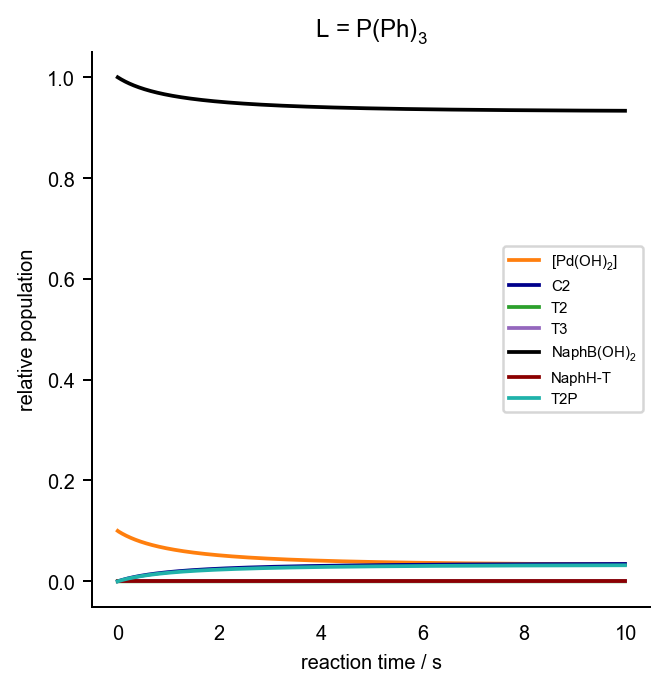

In [80]:
mk_params = {'MK_TFIN': 10.0, 'MK_TREP': 0.01, 'MK_DT': 0.1}
cmap = mpl.cm.get_cmap('tab10')
desired_traces = {'00-lpdoh2': cmap.colors[1],
                'pre-catalyst': cmap.colors[1],
                '05-c2': "darkblue",
                '15-t2': cmap.colors[2],
                '19-t3': cmap.colors[4], 
                'naphboh2': "black", 
                'naphh-t': "darkred",
                '41-t2p': 'lightseagreen'}

for ligand in ['t2p-2c-pph3']:
    D_NAME = ligand
    concentrations_dict = {'naphboh2': 0.02, 'pre-catalyst': 0.002, 'h2o': 0.07, 'ligand': 0.002} # units are in M 
    cs, df = get_mk_file(D_NAME=D_NAME, mk_params=mk_params, concentrations_dict=concentrations_dict)
    comp_yield = get_mk_profile(D_NAME=D_NAME, cs=cs, df=df, concentrations_dict=concentrations_dict, desired_traces=desired_traces)
    print(comp_yield)

## Auto-generation of microkinetic duration parameters

In [ ]:
threshold = 1e-08
auto_generate = True
if auto_generate:
    mk_params_df = pd.read_csv("small_microkinetic_parameters.csv")
    trial_df = pd.DataFrame()
    for _, row in mk_params_df.iterrows():
        converged = False
        trial_mk_params = {'MK_TFIN': 1E-1, 'MK_TREP': 1E-4, 'MK_DT': 1E-5}
        counter = 0
        while not converged:
            D_NAME = row['microkinetic_name']
            if row['microkinetic_type'] == 't2p':
                concentrations_dict = {'naphboh2': 0.02, 'pre-catalyst': 0.002, 'h2o': 0.07, 'ligand': 0.002} # units are in M 
            else:
                concentrations_dict = {'naphboh2': 0.02, '00-lpdoh2': 0.002, 'h2o': 0.07} # units are in M 
            cs, df = get_mk_file(D_NAME=D_NAME, mk_params=trial_mk_params, concentrations_dict=concentrations_dict)
            convergent_species = ['00-lpdoh2', 'naphh-t', '05-c2', '15-t2', '19-t3']
            if all([check_convergence(df, species) < threshold for species in convergent_species]):
                converged = True
                trial_mk_params['microkinetic_name'] = D_NAME
                trial_mk_params['comp_yield'] = get_mk_profile(D_NAME=D_NAME, cs=cs, df=df, concentrations_dict=concentrations_dict, desired_traces="", plot=False)
                trial_df = trial_df.append(trial_mk_params, ignore_index=True)
            elif counter == 8:
                converged = True
                print(f"{ligand} did not converge!")
            else:
                counter += 1
                for key in trial_mk_params.keys():
                    trial_mk_params[key] = trial_mk_params[key]*1E+1
    mk_params_df = pd.merge(mk_params_df, trial_df, on='microkinetic_name', how='left')
    mk_params_df.to_csv("autotuned_microkinetic_parameters.csv", index=False)
else:
    try:
        mk_params_df = pd.read_csv("autotuned_microkinetic_parameters.csv")
    except FileNotFoundError:
        print("Microkinetic parameters missing! Use autotuner")

# Get Yield Errors

In [35]:
ddg_df = pd.read_csv("ddg_1to5.csv")
ddg_df = ddg_df[ddg_df['equivs'] == 3.5]
fe = pd.read_csv("../fe_foranalysis.csv")
structures = ['C2', 'C3', 'C4', 'C5', 'CF1', 'F2', 'F3', 'F4', 'F5', 'H1', 'H2', 'H3', 'H4']
fe['max_name_eff_min'] = fe[['C2', 'C4', 'F2', 'F4', 'H1_eff_min', 'H3']].idxmax(axis=1)
fe['max_name_eff_max'] = fe[['C2', 'C4', 'F2', 'F4', 'H1_eff_max', 'H3']].idxmax(axis=1)
fe['delta-maxCT'] = fe.apply(lambda row: row['max_T-all-raw']-row['max_C'], axis=1)

In [8]:
def optimal_theoretical_yield(c2, c3, c4, f2, f3, f4, f5, h1, h2, h3, target, equivs, plot=False, mk_tfin=1E+6, D_NAME='theoretical'):
    yield_value = get_theoretical_yield(c4, f4, f5, h1, h2, h3, equivs, plot=False, mk_tfin=mk_tfin, D_NAME=D_NAME)
    print(yield_value, yield_value-target, target)
    return yield_value-target

def get_theoretical_yield(c2, c3, c4, f2, f3, f4, f5, h1, h2, h3, equivs, plot=False, mk_tfin=1E+6, D_NAME='theoretical'):
    concentrations_dict = {'C0': 0.002, 'NaphBOH2': 0.02, 'H2O': 1}
    concentrations_dict['H2O'] = concentrations_dict['NaphBOH2']*equivs
    mk_params =  {'MK_TFIN': mk_tfin}
    mk_params['MK_TREP'] = mk_params['MK_TFIN']/1E+1
    mk_params['MK_DT'] = mk_params['MK_TFIN']/1E+2
    ts_dict = {'C2': c2, 'C3':c3, 'C4': c4, 'F2': f2, 'F3':f3, 'F4': f4, 'F5': f5, 'H1': h1, 'H2': h2, 'H3': h3}
    cs, df, org_net = get_mk_file(D_NAME=D_NAME, mk_params=mk_params, concentrations_dict=concentrations_dict, ts_dict=ts_dict, prefix="")
    yields_final = get_mk_profile(D_NAME=D_NAME, cs=cs, df=df, yields=yields, prefix="", boronic="boh3", plot=plot)
    return yields_final[D_NAME]

def get_ligand_barriers(fe, ligand, structures):
    return fe[fe['name'] == ligand][structures].to_dict('records')[0]

def obtain_targeted_theoretical_yield(equiv_list, comp_yield_range):
    ddg_list = []
    for equivs in equiv_list:
        for target in comp_yield_range:
            res = optimize.root(optimal_theoretical_yield, x0=[20.0], args=(15.0, target, equivs, 1E+7))
            ddg_list.append([equivs, target, res['x'][0], res['x'][0]-15])
    ddg_df = pd.DataFrame(ddg_list, columns=['equivs', 'comp_yield', 'C4', 'ddG'])
    ddg_df['cm-10'] = ddg_df.apply(lambda row: get_theoretical_yield(row['C4']-1.0, 15.0, row['equivs']), axis=1)
    ddg_df['cp-10'] = ddg_df.apply(lambda row: get_theoretical_yield(row['C4']+1.0, 15.0, row['equivs']), axis=1)
    return ddg_df

def perturb_barrier(structure, energy, error):
    c_ts = ['C2', 'C4']
    t_ts = ['F2', 'F4', 'H1', 'H3']
    if structure in c_ts:
        return energy+error
    elif structure in t_ts:
        return energy-error
    else:
        return energy
    
def get_perturbed_barriers(error, fe, ligand, structures):
    ts_dict = get_ligand_barriers(fe, ligand, structures=structures)
    perturbed_barriers = [perturb_barrier(structure=key, energy=ts_dict[key], error=error) for key in ts_dict]
    return perturbed_barriers

def yield_error_optimization(error, fe, ligand, equivs, structures, plot=False, mk_tfin=1E+7, D_NAME='theoreticalv2'):
    #target = fe[fe['name'] == ligand]['exp_yield'].values[0]
    target = exp_yield_dict[ligand]
    perturbed_barriers = get_perturbed_barriers(error=error, fe=fe, ligand=ligand, structures=structures)
    #print(perturbed_barriers)
    perturbed_yield = get_theoretical_yield_array(array=perturbed_barriers, equivs=equivs, structures=structures, plot=plot, mk_tfin=mk_tfin, D_NAME='theoreticalv2')
    return perturbed_yield-target

def get_theoretical_yield_array(array, equivs, structures, plot=False, mk_tfin=1E+7, D_NAME='theoreticalv2'):    
    concentrations_dict = {'C0': 0.002, 'NaphBOH2': 0.02}
    concentrations_dict['H2O'] = concentrations_dict['NaphBOH2']*equivs
    mk_params =  {'MK_TFIN': mk_tfin}
    mk_params['MK_TREP'] = mk_params['MK_TFIN']/1E+1
    mk_params['MK_DT'] = mk_params['MK_TFIN']/1E+2
    ts_dict = {structure: array[i] for i, structure in enumerate(structures)}
    cs, df, org_net = get_mk_file(D_NAME=D_NAME, mk_params=mk_params, concentrations_dict=concentrations_dict, ts_dict=ts_dict, prefix="")
    yields_final = get_mk_profile(D_NAME=D_NAME, cs=cs, df=df, yields=yields, prefix="", boronic="boh3", plot=plot)
    #print(yields_final[D_NAME])
    return yields_final[D_NAME]

def get_water_error(yields=threefive_eq_yields, fe=fe, structures=structures):
    min_dict = {}
    max_dict = {}
    for ligand in threefive_eq_yields.keys():
        ts_dict = get_ligand_barriers(fe, ligand, structures=structures)
        min_yield = get_theoretical_yield_array(get_perturbed_barriers(error=0, fe=fe, ligand=ligand, structures=structures), equivs=1, plot=False, mk_tfin=1E+7, D_NAME='theoreticalv2', structures=structures)
        max_yield = get_theoretical_yield_array(get_perturbed_barriers(error=0, fe=fe, ligand=ligand, structures=structures), equivs=5, plot=False, mk_tfin=1E+7, D_NAME='theoreticalv2', structures=structures)
        min_dict[ligand] = min_yield
        max_dict[ligand] = max_yield
        return min_dict, max_dict

def get_perfect_error(ligands=threefive_eq_yields.keys(), fe=fe, structures=structures):
    perfect_dict = {}
    for ligand in ligands:
        target = fe[fe['name'] == ligand].values[0]
        res = optimize.root(yield_error_optimization, x0=[3], args=(fe, ligand, 3.5, structures, False, 1E+7, 'theoreticalv2'))
        perfect_dict[ligand] = res['x'][0]
    return perfect_dict

Diffussion barrier set to: 0.005524 hartrees, with threshold 0.000160 hartrees

          nfev=923
          njev=82
          nlu=82
          status=0
          success=True
          


/tmp/ipykernel_30/1102551361.py:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = mpl.cm.get_cmap('tab10')


0.00016131143332873067

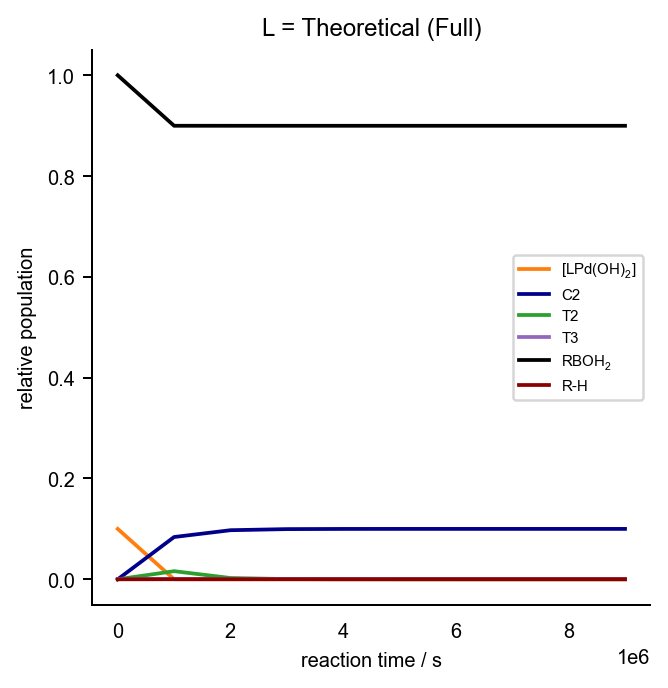

In [9]:
ligand = 'me4tbuxphos'
ts_dict = get_ligand_barriers(fe, ligand, structures=structures)
#factor = 2.87641583
#ts_dict['C3'] = 0.0
#ts_dict['C4'] = 15.0+factor
#ts_dict['C2'] -= 1.0
#ts_dict['F2'] = 15.0
#ts_dict['F4'] = 15.0
#ts_dict['F5'] = 0.0
#ts_dict['H1'] = 15.0
#ts_dict['H2'] = 0.0
#ts_dict['H3'] = 15.0
comp_yield = get_theoretical_yield(c2=ts_dict['C2'], c3=ts_dict['C3'], c4=ts_dict['C4'], f2=ts_dict['F2'], f3=ts_dict['F3'], f4=ts_dict['F4'], 
                                               f5=ts_dict['F5'], h1=ts_dict['H1'], h2=ts_dict['H2'], h3=ts_dict['H3'], 
                                               equivs=3.5, plot=True, mk_tfin=1E+7, D_NAME='theoreticalv2')
comp_yield

Diffussion barrier set to: 0.005524 hartrees, with threshold 0.000160 hartrees

          nfev=1137
          njev=102
          nlu=102
          status=0
          success=True
          


/tmp/ipykernel_30/1102551361.py:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = mpl.cm.get_cmap('tab10')


0.6993396509342885

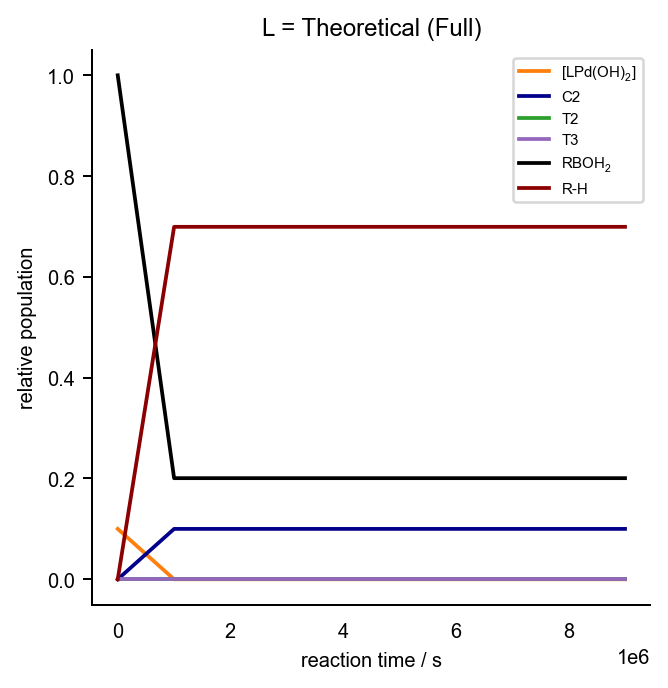

In [49]:
ligand = 'tbu'
get_theoretical_yield_array(get_perturbed_barriers(error=-0.25, fe=fe, ligand=ligand, structures=structures), equivs=3.5, structures=structures, plot=True, mk_tfin=1E+7, D_NAME='theoreticalv2')

/tmp/ipykernel_30/2354545769.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['< -1.5', '-1.0', '-0.5', '0.0', '0.5', '1.0', '> 1.5'])  # vertically oriented colorbar


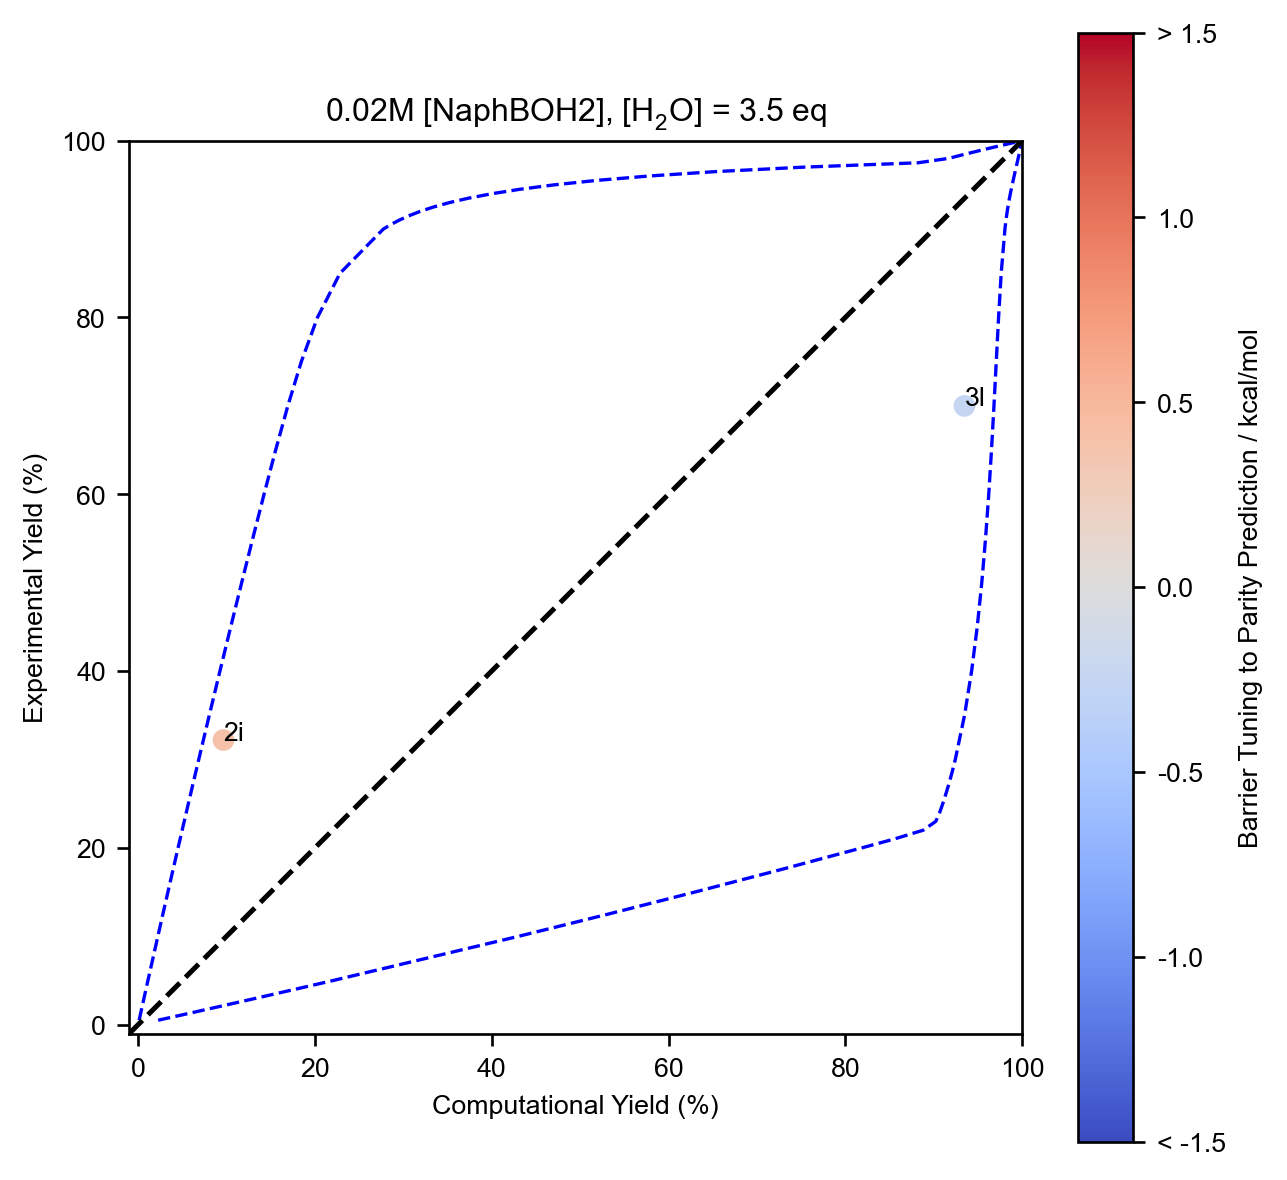

In [43]:
if True:
    #yield_df = pd.read_csv("../yield_df.csv")
    yield_df = pd.read_csv("../fe_foranalysis.csv")
else:
    yield_df = pd.DataFrame([exp_yield_dict, exp_error_dict, threefive_eq_yields, min_dict, max_dict])
    yield_df = yield_df.T
    yield_df = yield_df.reset_index()
    yield_df.columns = ['name', 'exp_yield', 'exp_error', 'comp_yield','comp_min', 'comp_max']
    yield_df['comp_min_diff'] = yield_df.apply(lambda row: max(0, row['comp_yield'] - row['comp_min']), axis=1)
    yield_df['comp_max_diff'] = yield_df.apply(lambda row: max(0, row['comp_max'] - row['comp_yield']), axis=1)

    
wanted_ligands = ['2i', '3l']
yield_df = yield_df[yield_df['exp_name'].isin(wanted_ligands)]
cmap = plt.get_cmap('coolwarm')
colorchoice='comp_error'
#norm = mpl.colors.Normalize(vmin=yield_df[colorchoice].min(), vmax=yield_df[colorchoice].max(),clip=False)
norm = mpl.colors.Normalize(vmin=-1.5, vmax=1.5,clip=False)
    

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=240)

g4 = sns.scatterplot(x='comp_yield', y='exp_yield', ax=ax, data=yield_df, s=50,
                    hue_norm=norm, hue='comp_error', palette='coolwarm',
                    )

g2 = sns.lineplot(x="nice-cm-10", y="nice_yield", ax=ax, data=ddg_df, 
                  color='b', linestyle='--', linewidth=1)
g3 = sns.lineplot(x="nice-cp-10", y="nice_yield", ax=ax, data=ddg_df, 
                  color='b', linestyle='--', linewidth=1)

for _, row in yield_df.iterrows():
        ax.text(row['comp_yield']*1.0001, row['exp_yield']*1.001, row['exp_name'], fontsize=8)
        
        

threshold = 1
ax.set_xlim([-1,100])
ax.set_ylim([-1,100])

ax.set_aspect('equal')

ax.axline((-10,-10), slope=1, linestyle='--', c='black')
ax.set_xlabel("Computational Yield (%)")
ax.set_ylabel("Experimental Yield (%)")
#ax.set_title("1.00M [NaphBOH2], 1.0eq water, $\Delta\Delta G^{\u2021}\pm$ 0.5 kcal/mol")
ax.get_legend().remove()

ax.set_title("0.02M [NaphBOH2], [H$_2$O] = 3.5 eq")

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                              label=colorchoice, ax=ax)

cbar.ax.set_yticklabels(['< -1.5', '-1.0', '-0.5', '0.0', '0.5', '1.0', '> 1.5'])  # vertically oriented colorbar

cbar.ax.set_ylabel('Barrier Tuning to Parity Prediction / kcal/mol', )

plt.savefig('theoyield.png', transparent=False, bbox_inches="tight")



/tmp/ipykernel_30/2232202743.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['< -1.5', '-1.0', '-0.5', '0.0', '0.5', '1.0', '> 1.5'])  # vertically oriented colorbar


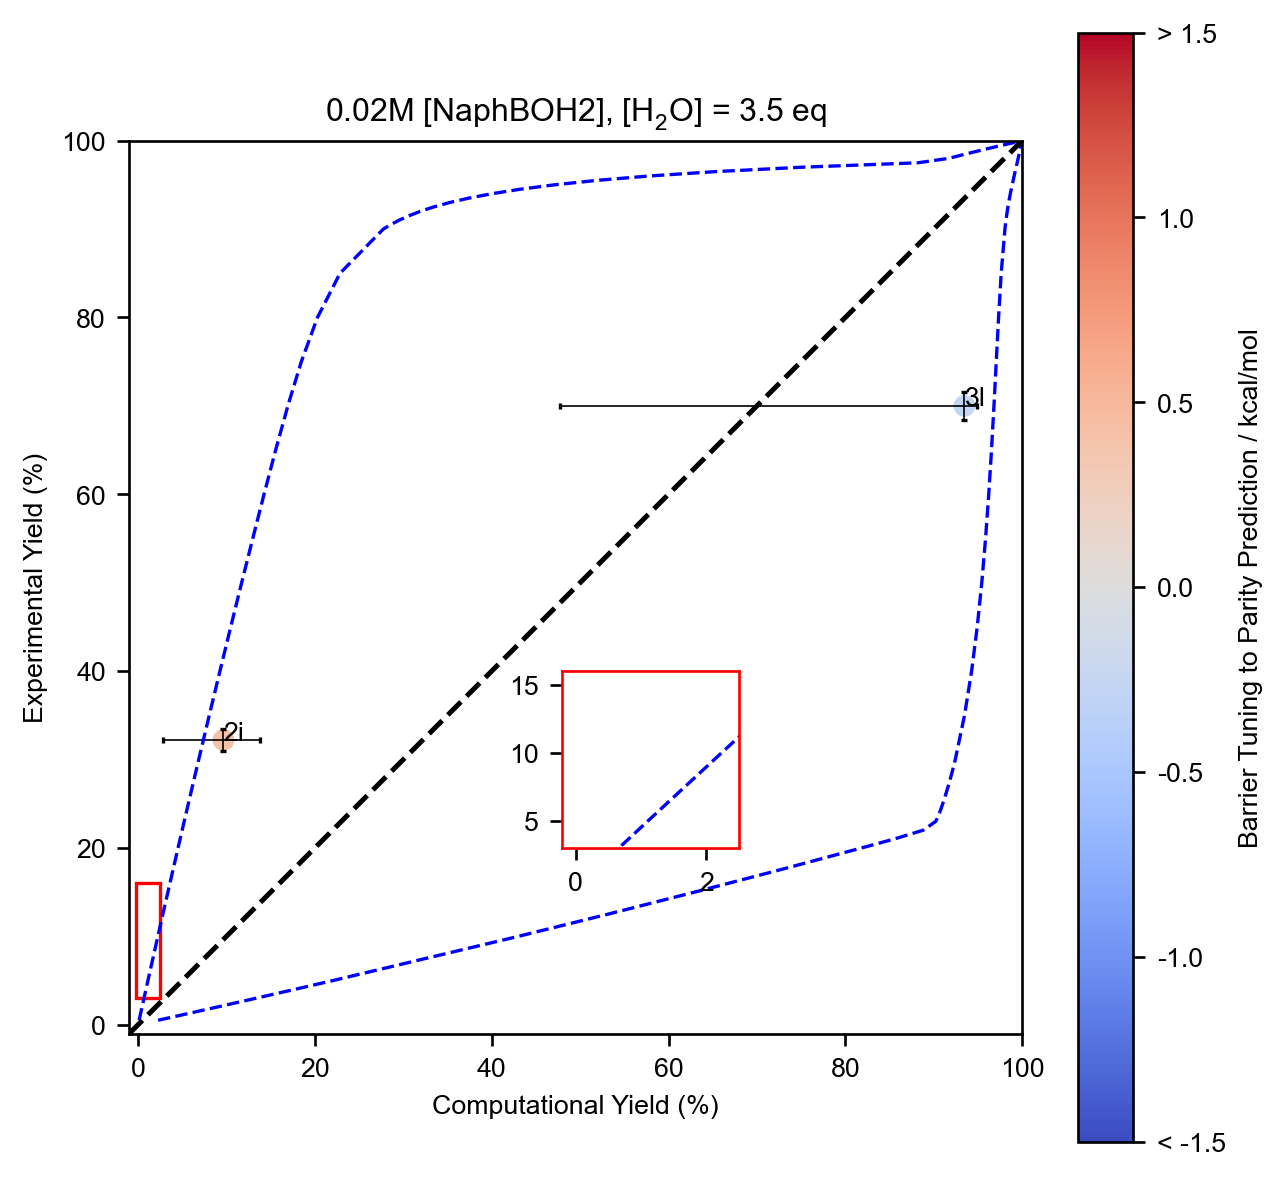

In [41]:
if False:
    if True:
        #yield_df = pd.read_csv("../yield_df.csv")
        yield_df = pd.read_csv("../fe_foranalysis.csv")
    else:
        yield_df = pd.DataFrame([exp_yield_dict, exp_error_dict, threefive_eq_yields, min_dict, max_dict])
        yield_df = yield_df.T
        yield_df = yield_df.reset_index()
        yield_df.columns = ['name', 'exp_yield', 'exp_error', 'comp_yield','comp_min', 'comp_max']
        yield_df['comp_min_diff'] = yield_df.apply(lambda row: max(0, row['comp_yield'] - row['comp_min']), axis=1)
        yield_df['comp_max_diff'] = yield_df.apply(lambda row: max(0, row['comp_max'] - row['comp_yield']), axis=1)

cmap = plt.get_cmap('coolwarm')
colorchoice='comp_error'
#norm = mpl.colors.Normalize(vmin=yield_df[colorchoice].min(), vmax=yield_df[colorchoice].max(),clip=False)
norm = mpl.colors.Normalize(vmin=-1.5, vmax=1.5,clip=False)
    

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=240)


if True:
    g4 = sns.scatterplot(x='comp_yield', y='exp_yield', ax=ax, data=yield_df, s=50,
                        hue_norm=norm, hue='comp_error', palette='coolwarm',
                        )
    g5 = plt.errorbar(x='comp_yield', y='exp_yield', 
                      xerr=(yield_df['comp_min_diff'], yield_df['comp_max_diff']), 
                      yerr='exp_error', 
                      data=yield_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5)

        
    if False:
        ax.axline((0,0.3), slope=1, linestyle='--', c='b')
        ax.axline((0.3,0.0), slope=1, linestyle='--', c='b')
    elif True:
        g2 = sns.lineplot(x="nice-cm-10", y="nice_yield", ax=ax, data=ddg_df, 
                          color='b', linestyle='--', linewidth=1)
        g3 = sns.lineplot(x="nice-cp-10", y="nice_yield", ax=ax, data=ddg_df, 
                          color='b', linestyle='--', linewidth=1)

ax.set_aspect('equal')

if True:
    threshold = 1
    ax.set_xlim([-1,100])
    ax.set_ylim([-1,100])
else:
    threshold = 0.35
    ax.set_xlim([-0.1,threshold])
    ax.set_ylim([-0.1,threshold])    

for _, row in yield_df[(yield_df['exp_yield'] >= 16) | (yield_df['comp_yield'] >= 2)].iterrows():
    if row['exp_name'] == '3g':
        ax.text(row['comp_yield']*0.91, row['exp_yield']*0.88, row['exp_name'], fontsize=8)
    else:
        ax.text(row['comp_yield']*1.0001, row['exp_yield']*1.001, row['exp_name'], fontsize=8)
    #ax.text(nice_new[key]*1.0001, nice_exp[key]*1.001, key, fontsize=6)
    
#for _, row in yield_df[(yield_df['exp_yield'] <= threshold) & (yield_df['comp_yield'] <= threshold)].iterrows():
#    ax.text(row['comp_yield']*1.0001, row['exp_yield']*1.001, row['exp_name'], fontsize=8)
    #ax.text(nice_new[key]*1.0001, nice_exp[key]*1.001, key, fontsize=6)
ax.axline((-10,-10), slope=1, linestyle='--', c='black')
ax.set_xlabel("Computational Yield (%)")
ax.set_ylabel("Experimental Yield (%)")
#ax.set_title("1.00M [NaphBOH2], 1.0eq water, $\Delta\Delta G^{\u2021}\pm$ 0.5 kcal/mol")

ax.set_title("0.02M [NaphBOH2], [H$_2$O] = 3.5 eq")
#ax.set_title("0.02M [NaphBOH2], [H$_2$O] = [1.0, 3.5, 5.0] eq., $\Delta\Delta G^{\u2021}\pm$ 1.0 kcal/mol", size=8)
ax.get_legend().remove()

x_inset1_start = -0.2
x_inset1_end = 2.5
y_inset1_start = 3
y_inset1_end = 16

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
    
axin1 = ax.inset_axes([48, 20, 20, 20], transform=ax.transData)
#axin1 = ax.inset_axes([20, 47, 25, 30], transform=ax.transData)
g6 = sns.scatterplot(x='comp_yield', y='exp_yield', ax=axin1, data=yield_df, s=50, 
                     hue_norm=norm, hue='comp_error', palette='coolwarm',
                    )
g7 = axin1.errorbar(x='comp_yield', y='exp_yield', 
                  xerr=(yield_df['comp_min_diff'], yield_df['comp_max_diff']), 
                  yerr='exp_error', 
                  data=yield_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5)

g2 = sns.lineplot(x="nice-cm-10", y="nice_yield", ax=axin1, data=ddg_df, 
                  color='b', linestyle='--', linewidth=1)
g3 = sns.lineplot(x="nice-cp-10", y="nice_yield", ax=axin1, data=ddg_df, 
                  color='b', linestyle='--', linewidth=1)
axin1.get_legend().set_visible(False)
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])
axin1.set_xlabel("")
axin1.set_ylabel("")

#ax.get_legend().remove()

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                              label=colorchoice, ax=ax)

cbar.ax.set_yticklabels(['< -1.5', '-1.0', '-0.5', '0.0', '0.5', '1.0', '> 1.5'])  # vertically oriented colorbar

cbar.ax.set_ylabel('Barrier Tuning to Parity Prediction / kcal/mol', )

for _, row in yield_df[(yield_df['exp_yield'] <= 16) & (yield_df['comp_yield'] <= 2)].iterrows():
    if row['exp_name'] == '2g':
        axin1.text(row['comp_yield']*0.91, row['exp_yield']*1.401, row['exp_name'], fontsize=8)
    elif row['exp_name'] == '2e':
        axin1.text(row['comp_yield']*1.0001, row['exp_yield']*1.001, row['exp_name'], fontsize=8)
    else:
        axin1.text(row['comp_yield']*1.0001, row['exp_yield']*1.001, row['exp_name'], fontsize=8)

        
for spine in axin1.spines.values():
    spine.set_edgecolor('red')

plt.savefig('theoyield.png', transparent=False, bbox_inches="tight")



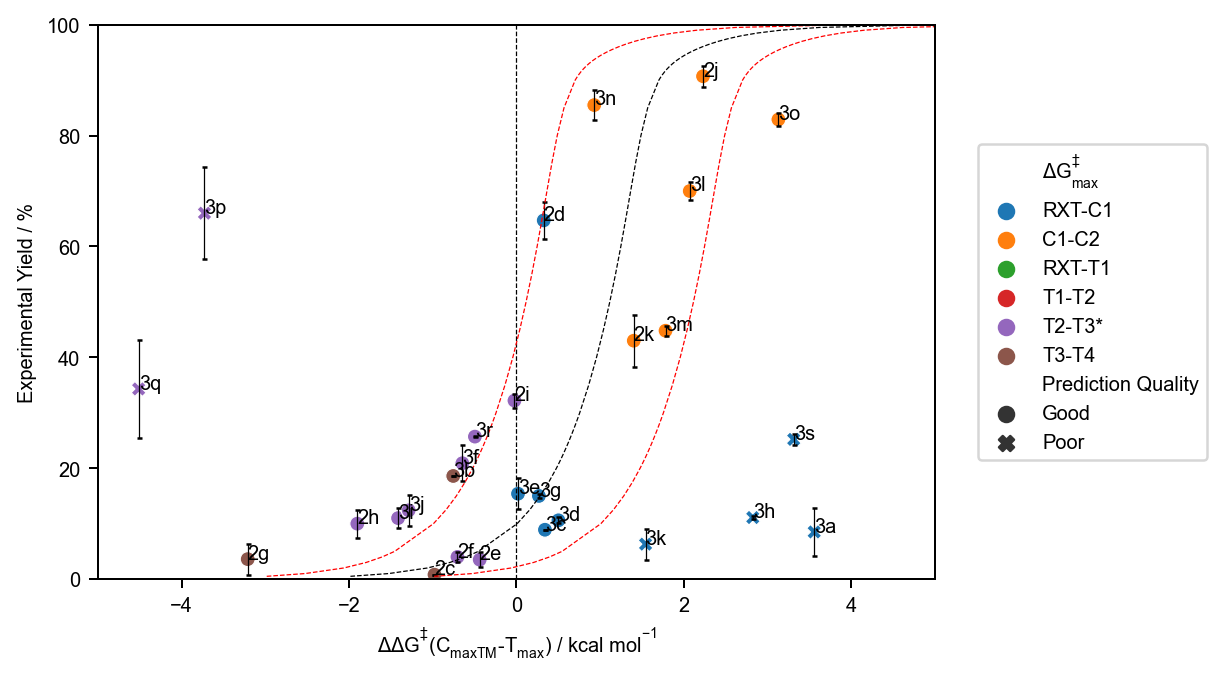

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=180)
hue_order = ['C2', 'C4', 'F2', 'F4', 'H1_eff_min', 'H3']

x = 'ddG_Cteff'
y = 'exp_yield'
g = sns.scatterplot(x=x, y=y, data=fe, hue_order=hue_order, hue='max_name_eff_min', palette='tab10',style=fe['prediction_quality'], ax=ax)
g5 = plt.errorbar(x=x, y=y, yerr='exp_error', data=fe, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
#g = sns.scatterplot(x=x, y=y, data=df, hue='max_name', palette='tab10',style=fe['prediction_quality'], ax=ax)
for _, row in fe.iterrows():
    ax.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8,)
ax.set_xlabel('$\Delta\Delta$G$^{\u2021}$(C$_{maxTM}$-T$_{max}$) / kcal mol$^{-1}$')
ax.set_ylabel('Experimental Yield / %')
ax.axvline(0, linestyle='--', color='black', linewidth=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([0, 100])

handles, labels = plt.gca().get_legend_handles_labels()
#order = [0,1,2,3,4,5,6]
#order = [0,1,2,3]

g = sns.lineplot(x='correctedddG', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='black', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='correctedddG-p', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='r', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='correctedddG-m', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='r', ax=ax, linewidth=0.5, linestyle='--')


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()

plt.savefig('expvsmaxtc.png', transparent=True, bbox_inches="tight")

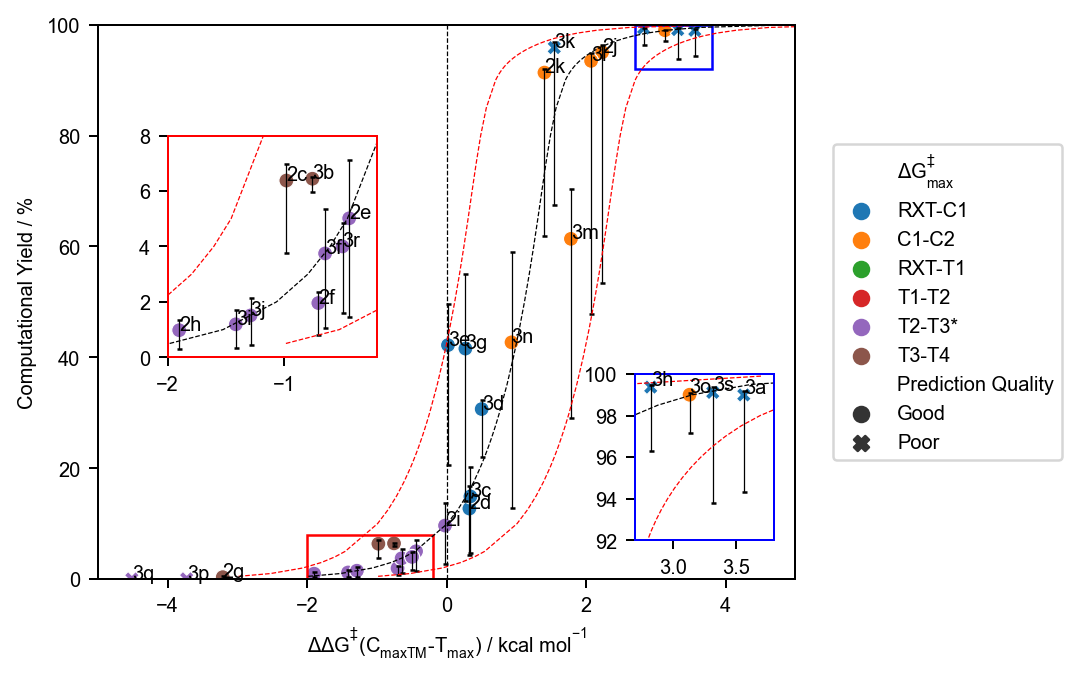

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=180)
hue_order = ['C2', 'C4', 'F2', 'F4', 'H1_eff_min', 'H3']

x = 'ddG_Cteff'
y = 'comp_yield'
g = sns.scatterplot(x=x, y=y, data=fe, hue_order=hue_order, hue='max_name_eff_min', palette='tab10',style=fe['prediction_quality'], ax=ax)
g5 = plt.errorbar(x=x, y=y, yerr=(fe['comp_min_diff'], fe['comp_max_diff']), data=fe, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')

ax.set_xlabel('$\Delta\Delta$G$^{\u2021}$(C$_{maxTM}$-T$_{max}$) / kcal mol$^{-1}$')
ax.set_ylabel('Computational Yield / %')
ax.axvline(0, linestyle='--', color='black', linewidth=0.5)
#ax.set_xlim([-max(df[x])-0.5, max(df[x])+0.5])
ax.set_xlim([-5, 5])
ax.set_ylim([0,100])

handles, labels = plt.gca().get_legend_handles_labels()
#order = [0,1,2,3,4,5,6]
#order = [0,1,2,3]

g = sns.lineplot(x='correctedddG', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='black', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='correctedddG-p', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='r', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='correctedddG-m', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='r', ax=ax, linewidth=0.5, linestyle='--')


x_inset1_start = -2
x_inset1_end = -0.2
y_inset1_start = 0
y_inset1_end = 8

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
    
axin1 = ax.inset_axes([-4, 40, 3, 40], transform=ax.transData)
g = sns.scatterplot(x=x, y=y, data=fe, hue_order=hue_order, hue='max_name_eff_min', palette='tab10',style=fe['prediction_quality'], ax=axin1)
g5 = axin1.errorbar(x=x, y=y, yerr=(fe['comp_min_diff'], fe['comp_max_diff']), data=fe, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')

g = sns.lineplot(x='correctedddG', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='black', ax=axin1, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='correctedddG-p', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='r', ax=axin1, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='correctedddG-m', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='r', ax=axin1, linewidth=0.5, linestyle='--')

axin1.get_legend().set_visible(False)
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])
axin1.set_xlabel("")
axin1.set_ylabel("")

x_inset2_start = 2.7
x_inset2_end = 3.8
y_inset2_start = 92
y_inset2_end = 100

rect2 = mpl.patches.Rectangle((x_inset2_start, y_inset2_start), x_inset2_end-x_inset2_start, y_inset2_end-y_inset2_start, 
                              linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect2)
    
axin2 = ax.inset_axes([2.7, 7, 2, 30], transform=ax.transData)
g = sns.scatterplot(x=x, y=y, data=fe, hue_order=hue_order, hue='max_name_eff_min', palette='tab10',style=fe['prediction_quality'], ax=axin2)
g5 = axin2.errorbar(x=x, y=y, yerr=(fe['comp_min_diff'], fe['comp_max_diff']), data=fe, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')

g = sns.lineplot(x='correctedddG', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='black', ax=axin2, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='correctedddG-p', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='r', ax=axin2, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='correctedddG-m', y='nice_yield', data=ddg_df[ddg_df['equivs']==3.5], c='r', ax=axin2, linewidth=0.5, linestyle='--')

axin2.get_legend().set_visible(False)
axin2.set_xlim([x_inset2_start,x_inset2_end])
axin2.set_ylim([y_inset2_start,y_inset2_end])
axin2.set_xlabel("")
axin2.set_ylabel("")


inset_1_list = ['2h', '3i', '3j', '2c', '3b', '2e', '2f', '3r', '3f']
inset_2_list = ['3h', '3o', '3s', '3a']
for _, row in fe.iterrows():
    if row['exp_name'] not in inset_1_list and row['exp_name'] not in inset_2_list:
        ax.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    if row['exp_name'] in inset_1_list:
        axin1.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)  
    if row['exp_name'] in inset_2_list:
        axin2.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
text_list = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="$\Delta$G$_{max}$").get_texts()

for spine in axin1.spines.values():
    spine.set_edgecolor('r')
for spine in axin2.spines.values():
    spine.set_edgecolor('b')
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()

plt.savefig('compvsmaxtc.png', transparent=False, bbox_inches="tight")

/tmp/ipykernel_30/868532241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff['vbur_near_vbur_min_percent'] = ff['vbur_near_vbur_min']/0.9


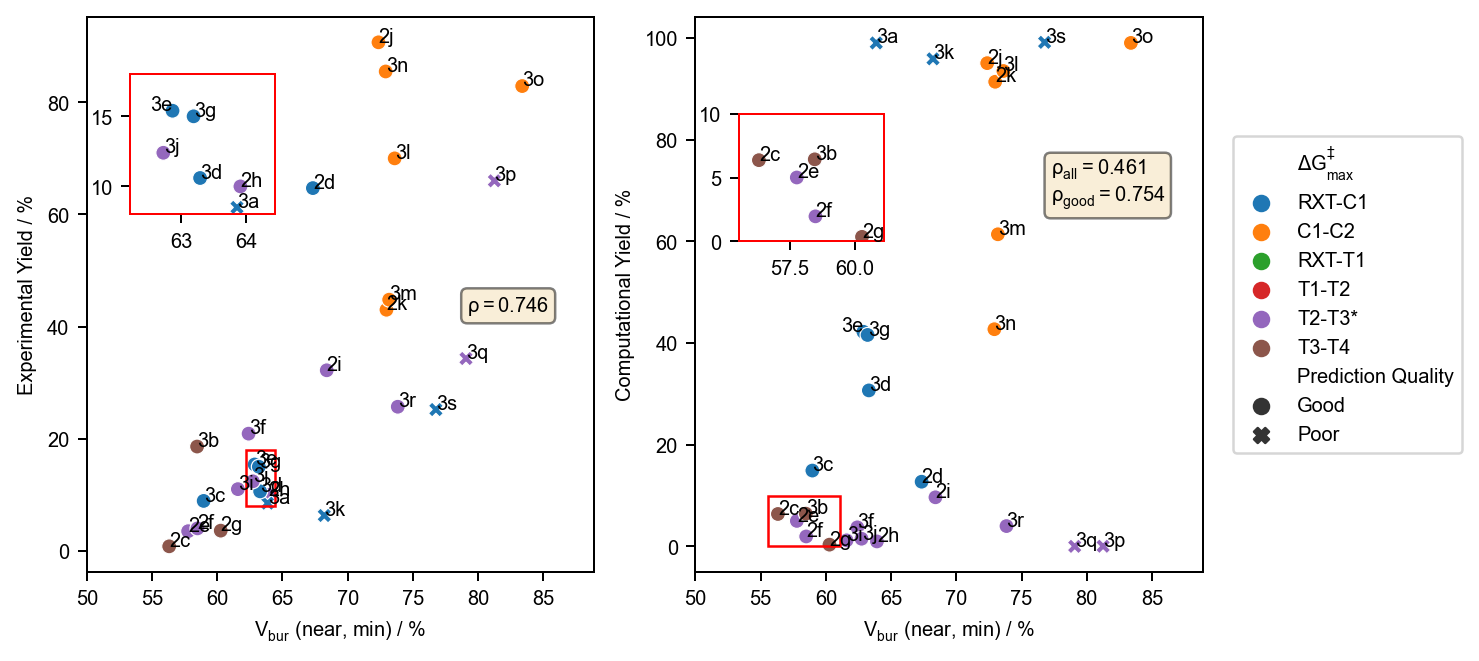

In [14]:
ff = fe.dropna()

ff['vbur_near_vbur_min_percent'] = ff['vbur_near_vbur_min']/0.9

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=180)
hue_order = ['C2', 'C4', 'F2', 'F4', 'H1_eff_min', 'H3']
x = 'vbur_near_vbur_min_percent'
y = 'exp_yield'
g = sns.scatterplot(x=x, y=y, data=ff, hue_order=hue_order, palette='tab10', hue='max_name_eff_min',  style=ff['prediction_quality'], ax=ax[0])
#g = sns.scatterplot(x=x, y=y, data=ff, hue=ff['max_name_eff_min'], hue_order=hue_order, palette='tab10', style=ff['ligand-type'], ax=ax[0])
#g = sns.scatterplot(x=x, y=y, data=ff, ax=ax[0])
for _, row in ff.iterrows():
    ax[0].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)

ax[0].get_legend().set_visible(False)
ax[0].set_xlim([45/0.9,80/0.9])

x_inset1_start = 56/0.9
x_inset1_end = 58/0.9
y_inset1_start = 8
y_inset1_end = 18

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect1)

axin1 = ax[0].inset_axes([48/0.9, 60, 10/0.9, 25], transform=ax[0].transData)
g_axin1 = sns.scatterplot(x=x, y=y, data=ff, hue_order=hue_order, palette='tab10',style=ff['prediction_quality'], hue='max_name_eff_min', ax=axin1)
axin1.get_legend().set_visible(False)
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])


for _, row in ff.iterrows():
    if (axin1.get_xlim()[0] <= row[x] < axin1.get_xlim()[1]) & (axin1.get_ylim()[0] <= row[y] < axin1.get_ylim()[1]):
        if row['exp_name'] != '3e':
            axin1.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin1.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[0].set_xlabel("V$_{bur}$ (near, min) / %")
ax[0].set_ylabel("Experimental Yield / %")
axin1.set_xlabel("")
axin1.set_ylabel("")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.75, 0.5, r'$\rho=%.3f$' % (pearsonr(ff['exp_yield'], ff['vbur_near_vbur_min_percent'])[0]),
           transform=ax[0].transAxes, verticalalignment='top', bbox=props)

x = 'vbur_near_vbur_min_percent'
y = 'comp_yield'
g2 = sns.scatterplot(x=x, y=y, data=ff, palette='tab10',hue_order=hue_order, hue='max_name_eff_min', style=ff['prediction_quality'], ax=ax[1])
#g2 = sns.scatterplot(x=x, y=y, data=ff, hue=ff['max_name_eff_min'], hue_order=hue_order, palette='tab10', style=ff['ligand-type'], ax=ax[1])
#g = sns.scatterplot(x=x, y=y, data=ff, ax=ax[0])
for _, row in ff.iterrows():
    if row['exp_name'] != '3e':
        ax[1].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    else:
        ax[1].text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

        
ax[1].set_xlim([45/0.9,80/0.9])


x_inset2_start = 50/0.9
x_inset2_end = 55/0.9
y_inset2_start = 0
y_inset2_end = 10

rect2 = mpl.patches.Rectangle((x_inset2_start, y_inset2_start), x_inset2_end-x_inset2_start, y_inset2_end-y_inset2_start, linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect2)
        
axin2 = ax[1].inset_axes([48/0.9, 60, 10/0.9, 25], transform=ax[1].transData)
g_axin2 = sns.scatterplot(x=x, y=y, data=ff, hue_order=hue_order, palette='tab10',style=ff['prediction_quality'], hue='max_name_eff_min', ax=axin2)
axin2.get_legend().set_visible(False)
axin2.set_xlim([x_inset2_start,x_inset2_end])
axin2.set_ylim([y_inset2_start,y_inset2_end])

for _, row in ff.iterrows():
    if (axin2.get_xlim()[0] <= row[x] < axin2.get_xlim()[1]) & (axin2.get_ylim()[0] <= row[y] < axin2.get_ylim()[1]):
        if row['exp_name'] != '3e':
            axin2.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8, ha='left')
        else:
            axin2.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[1].set_xlabel("V$_{bur}$ (near, min) / %")
ax[1].set_ylabel("Computational Yield / %")
axin2.set_xlabel("")
axin2.set_ylabel("")

all_r = pearsonr(ff['vbur_near_vbur_min_percent'], ff['comp_yield'])[0]
di = ff[ff['prediction_quality'] == 'Good']
good_r = pearsonr(di['vbur_near_vbur_min_percent'], di['comp_yield'])[0]
#dg = ff[ff['vbur_near_vbur_min_percent'] <= 75]
dh = ff[ff['prediction_quality'] == 'Good']
some_r = pearsonr(dh['vbur_near_vbur_min_percent'], dh['comp_yield'])[0]


ax[1].text(0.7, 0.75, rf"$\rho_{{all}}={all_r:.3f}$"+"\n"+rf"$\rho_{{good}}={some_r:.3f}$", transform=ax[1].transAxes, verticalalignment='top', bbox=props)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()

for spine in axin1.spines.values():
    spine.set_edgecolor('r')
    
for spine in axin2.spines.values():
    spine.set_edgecolor('r')

plt.savefig('vburnearminyields.png', transparent=True, bbox_inches="tight")
             

/tmp/ipykernel_30/244199414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff['vbur_vbur_min_percent'] = ff['vbur_vbur_min']/1.8


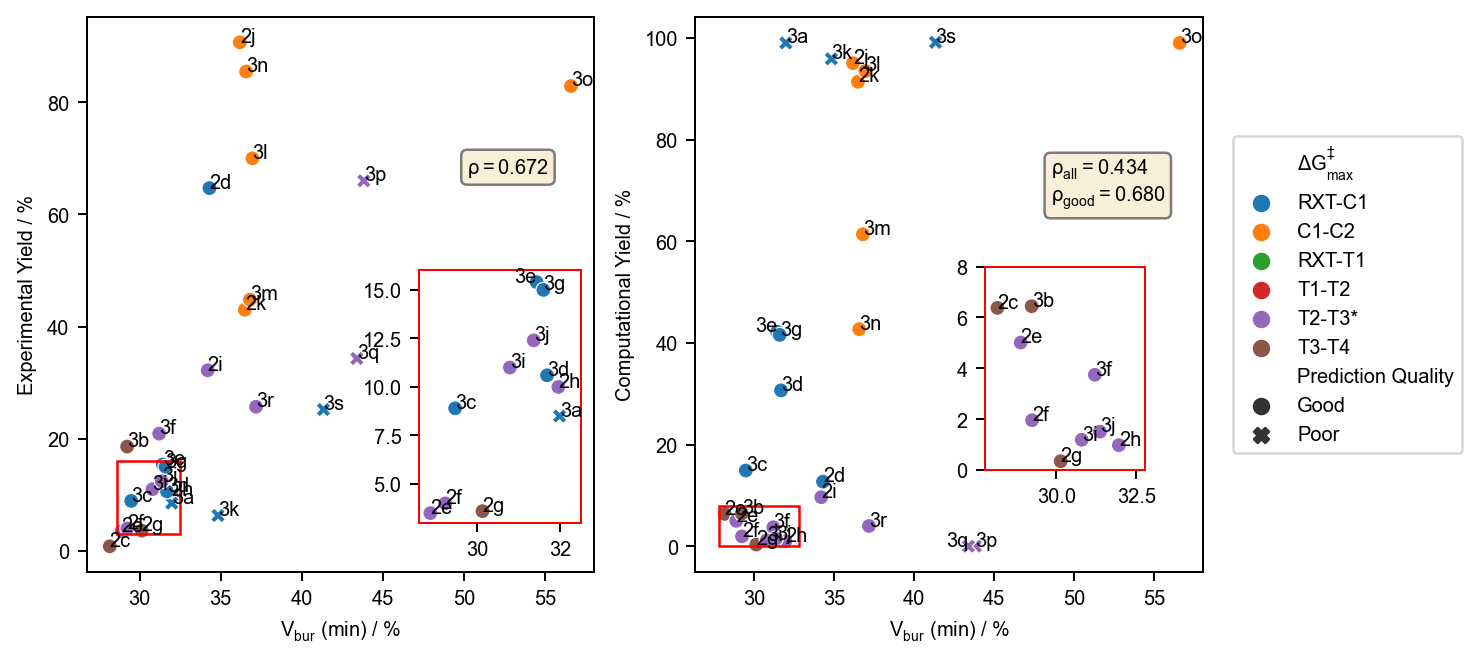

In [15]:
ff['vbur_vbur_min_percent'] = ff['vbur_vbur_min']/1.8

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=180)
hue_order = ['C2', 'C4', 'F2', 'F4', 'H1_eff_min', 'H3']
x = 'vbur_vbur_min_percent'
y = 'exp_yield'
g = sns.scatterplot(x=x, y=y, data=ff, hue_order=hue_order, palette='tab10', hue='max_name_eff_min',  style=ff['prediction_quality'], ax=ax[0])
#g = sns.scatterplot(x=x, y=y, data=ff, hue=ff['max_name_eff_min'], hue_order=hue_order, palette='tab10', style=ff['ligand-type'], ax=ax[0])
#g = sns.scatterplot(x=x, y=y, data=ff, ax=ax[0])
for _, row in ff.iterrows():
    ax[0].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)

ax[0].get_legend().set_visible(False)

x_inset1_start = 51.5/1.8
x_inset1_end = 58.5/1.8
y_inset1_start = 3
y_inset1_end = 16

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect1)
    
axin1 = ax[0].inset_axes([85/1.8, 5, 18/1.8, 45], transform=ax[0].transData)
g_axin1 = sns.scatterplot(x=x, y=y, data=ff, hue_order=hue_order, palette='tab10',style=ff['prediction_quality'], hue='max_name_eff_min', ax=axin1)
axin1.get_legend().set_visible(False)
axin1.set_xlim([51.5/1.8,58.5/1.8])
axin1.set_ylim([3,16])

for _, row in ff.iterrows():
    if (axin1.get_xlim()[0] <= row[x] < axin1.get_xlim()[1]) & (axin1.get_ylim()[0] <= row[y] < axin1.get_ylim()[1]):
        if row['exp_name'] != '3e':
            axin1.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin1.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[0].set_xlabel("V$_{bur}$ (min) / %")
ax[0].set_ylabel("Experimental Yield / %")
axin1.set_xlabel("")
axin1.set_ylabel("")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.75, 0.75, r'$\rho=%.3f$' % (pearsonr(ff['exp_yield'], ff['vbur_vbur_min_percent'])[0]),
           transform=ax[0].transAxes, verticalalignment='top', bbox=props)

axin2_goleft = ['3e', '3q']

x = 'vbur_vbur_min_percent'
y = 'comp_yield'
g2 = sns.scatterplot(x=x, y=y, data=ff, palette='tab10',hue_order=hue_order, hue='max_name_eff_min', style=ff['prediction_quality'], ax=ax[1])
#g2 = sns.scatterplot(x=x, y=y, data=ff, hue=ff['max_name_eff_min'], hue_order=hue_order, palette='tab10', style=ff['ligand-type'], ax=ax[1])
#g = sns.scatterplot(x=x, y=y, data=ff, ax=ax[0])
for _, row in ff.iterrows():
    if row['exp_name'] not in axin2_goleft:
        ax[1].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    else:
        ax[1].text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

x_inset2_start = 50/1.8
x_inset2_end = 59/1.8
y_inset2_start = 0
y_inset2_end = 8

rect2 = mpl.patches.Rectangle((x_inset2_start, y_inset2_start), x_inset2_end-x_inset2_start, y_inset2_end-y_inset2_start, linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect2)
        
        
        
axin2 = ax[1].inset_axes([80/1.8, 15, 18/1.8, 40], transform=ax[1].transData)
g_axin2 = sns.scatterplot(x=x, y=y, data=ff, palette='tab10', hue_order=hue_order, hue='max_name_eff_min', style=ff['prediction_quality'],ax=axin2)
axin2.get_legend().set_visible(False)
axin2.set_xlim([50/1.8,59/1.8])
axin2.set_ylim([0,8])



for _, row in ff.iterrows():
    if (axin2.get_xlim()[0] <= row[x] < axin2.get_xlim()[1]) & (axin2.get_ylim()[0] <= row[y] < axin2.get_ylim()[1]):
        if row['exp_name'] not in axin2_goleft:
            axin2.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin2.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[1].set_xlabel("V$_{bur}$ (min) / %")
ax[1].set_ylabel("Computational Yield / %")
axin2.set_xlabel("")
axin2.set_ylabel("")

all_r = pearsonr(ff['vbur_vbur_min_percent'], ff['comp_yield'])[0]
di = ff[ff['prediction_quality'] == 'Good']
good_r = pearsonr(di['vbur_vbur_min_percent'], di['comp_yield'])[0]
dg = ff[ff['vbur_vbur_min_percent'] <= 100]
dh = dg[dg['prediction_quality'] == 'Good']
some_r = pearsonr(dh['vbur_vbur_min_percent'], dh['comp_yield'])[0]


ax[1].text(0.7, 0.75, rf"$\rho_{{all}}={all_r:.3f}$"+"\n"+rf"$\rho_{{good}}={some_r:.3f}$", transform=ax[1].transAxes, verticalalignment='top', bbox=props)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()

for spine in axin1.spines.values():
    spine.set_edgecolor('r')
    
for spine in axin2.spines.values():
    spine.set_edgecolor('r')

plt.savefig('vburminyields.png', transparent=False, bbox_inches="tight")

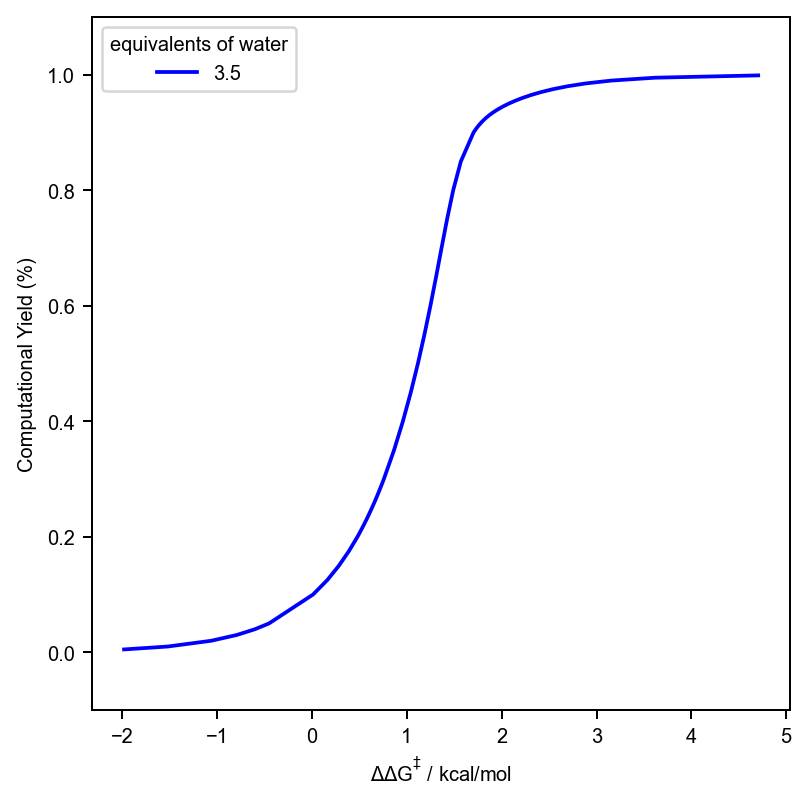

In [30]:
ddg_df = pd.read_csv("ddg_1to5.csv")
ddg_df['correctedddG'] = ddg_df['ddG'] - np.log(1/(ddg_df['equivs']*0.02))*8.314*333.15/1000/4.184
ddg_df['correctedddG-p'] = ddg_df['correctedddG'] + 1
ddg_df['correctedddG-m'] = ddg_df['correctedddG'] - 1

fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=180)

#for equivs in [2.0, 3.5, 5.0]:
#for equivs in set(ddg_df['equivs']):
#g1 = sns.lineplot(x="correctedddG", y="comp_yield", ax=ax, data=ddg_df[ddg_df['equivs'] == 1.0], label="1.0", color='r')
g1 = sns.lineplot(x="correctedddG", y="comp_yield", ax=ax, data=ddg_df[ddg_df['equivs'] == 3.5], label="3.5", color='b')
#g1 = sns.lineplot(x="correctedddG", y="comp_yield", ax=ax, data=ddg_df[ddg_df['equivs'] == 5.0], label="5.0", color='g')

#ax.set_aspect('equal')
ax.set_ylim([-0.1,1.1])
#ax.set_xlim([-1,9])
#ax.axline((-10,-10), slope=1, linestyle='--', c='black')
ax.set_ylabel("Computational Yield (%)")
ax.set_xlabel("$\Delta\Delta G^{\u2021}$ / kcal/mol")
#ax.set_title("0.02M [NaphBOH2], 3.5eq water, $\Delta\Delta G^{\u2021}\pm$ 1.0 kcal/mol")
ax.legend(title="equivalents of water")


#plt.savefig('theoyield.png', transparent=True, bbox_inches="tight")

/tmp/ipykernel_30/613576406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff['vbur_vbur_min_percent'] = ff['vbur_vbur_min']/1.8


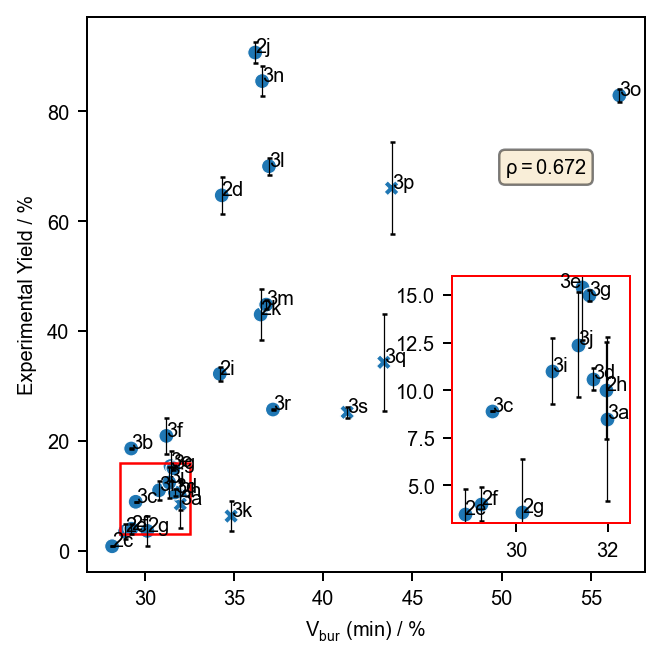

In [17]:
ff['vbur_vbur_min_percent'] = ff['vbur_vbur_min']/1.8

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=180)
hue_order = ['C2', 'C4', 'F2', 'F4', 'H1_eff_min', 'H3']
x = 'vbur_vbur_min_percent'
y = 'exp_yield'
g = sns.scatterplot(x=x, y=y, data=ff, style=ff['prediction_quality'], ax=ax)
g5 = ax.errorbar(x=x, y=y, yerr='exp_error', data=ff, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')

#g = sns.scatterplot(x=x, y=y, data=ff, hue=ff['max_name_eff_min'], hue_order=hue_order, palette='tab10', style=ff['ligand-type'], ax=ax)
#g = sns.scatterplot(x=x, y=y, data=ff, ax=ax)
for _, row in ff.iterrows():
    ax.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)

ax.get_legend().set_visible(False)

x_inset1_start = 51.5/1.8
x_inset1_end = 58.5/1.8
y_inset1_start = 3
y_inset1_end = 16

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
    
axin1 = ax.inset_axes([85/1.8, 5, 18/1.8, 45], transform=ax.transData)
g_axin1 = sns.scatterplot(x=x, y=y, data=ff, ax=axin1)
#axin1.get_legend().set_visible(False)
axin1.set_xlim([51.5/1.8,58.5/1.8])
axin1.set_ylim([3,16])


g5 = axin1.errorbar(x=x, y=y, yerr='exp_error', data=ff, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')

for _, row in ff.iterrows():
    if (axin1.get_xlim()[0] <= row[x] < axin1.get_xlim()[1]) & (axin1.get_ylim()[0] <= row[y] < axin1.get_ylim()[1]):
        if row['exp_name'] != '3e':
            axin1.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin1.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax.set_xlabel("V$_{bur}$ (min) / %")
ax.set_ylabel("Experimental Yield / %")
axin1.set_xlabel("")
axin1.set_ylabel("")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.75, 0.75, r'$\rho=%.3f$' % (pearsonr(ff['exp_yield'], ff['vbur_vbur_min_percent'])[0]),
           transform=ax.transAxes, verticalalignment='top', bbox=props)


"""
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()
"""
for spine in axin1.spines.values():
    spine.set_edgecolor('r')
    

plt.savefig('vburminyields.png', transparent=False, bbox_inches="tight")

In [18]:
fe

,exp_name,name,exp_yield,exp_error,comp_yield,comp_min,comp_max,comp_min_diff,comp_max_diff,comp_error,prediction_quality,C2,C3,C4,C5,CF1,F2,F3,F4,F5,H1,H1_eff_min,H1_eff_max,H2,H3,H4,max_C,max_C_name,max_T-TM,max_T-all-raw,max_T-all-raw_name,max_name,max_T-eff,ddG_Cteff,max_name_eff_min,max_name_eff_max,delta-maxCT,smiles,ID,vmin_vmin_boltz,vmin_r_boltz,fmo_e_homo_boltz,fmo_e_lumo_boltz,fmo_mu_boltz,fmo_eta_boltz,fmo_omega_boltz,somo_ra_boltz,somo_rc_boltz,nbo_P_boltz,nbo_P_ra_boltz,...,vbur_far_vbur_max,vbur_far_vbur_delta,vbur_far_vbur_vburminconf,vbur_near_vtot_boltz,vbur_near_vtot_min,vbur_near_vtot_max,vbur_near_vtot_delta,vbur_near_vtot_vburminconf,vbur_far_vtot_boltz,vbur_far_vtot_min,vbur_far_vtot_max,vbur_far_vtot_delta,vbur_far_vtot_vburminconf,sterimol_B1_boltz,sterimol_B1_min,sterimol_B1_max,sterimol_B1_delta,sterimol_B1_vburminconf,sterimol_B5_boltz,sterimol_B5_min,sterimol_B5_max,sterimol_B5_delta,sterimol_B5_vburminconf,sterimol_L_boltz,sterimol_L_min,sterimol_L_max,sterimol_L_delta,sterimol_L_vburminconf,sterimol_burB1_boltz,sterimol_burB1_min,sterimol_burB1_max,sterimol_burB1_delta,sterimol_burB1_vburminconf,sterimol_burB5_boltz,sterimol_burB5_min,sterimol_burB5_max,sterimol_burB5_delta,sterimol_burB5_vburminconf,sterimol_burL_boltz,sterimol_burL_min,sterimol_burL_max,sterimol_burL_delta,sterimol_burL_vburminconf,smiles_desc,PC1,PC2,PC3,PC4,umap1,umap2
0,2c,pph3,0.8,0.01,6.377688,3.749830,6.990550,2.627858,0.612863,-0.699660,Good,13.478278,1.946535,5.837094,-30.003742,2.656875,10.059606,2.419677,13.537891,-3.774470,11.111312,12.871743,13.094487,-3.928210,14.456565,-10.534631,13.478278,C2,13.537891,14.456565,H3,H3,14.456565,-0.978287,H3,H3,0.978287,c1ccc(P(c2ccccc2)c2ccccc2)cc1,17.0,-0.048230,1.860160,-0.228390,-0.029490,-0.128940,0.198900,0.041794,0.060510,-0.394380,0.798270,0.746250,...,0.000000,0.000000,0.000000,302.715907,302.715907,302.715907,0.000000,302.715907,0.000000,0.000000,0.000000,0.000000,0.000000,4.287868,4.287868,4.287868,0.000000,4.287868,6.323592,6.323592,6.323592,0.000000,6.323592,7.181925,7.181925,7.181925,0.000000,7.181925,4.278755,4.278755,4.278755,0.000000,4.278755,6.029300,6.029300,6.029300,0.000000,6.029300,6.914110,6.914110,6.914110,0.000000,6.914110,c1ccc(P(c2ccccc2)c2ccccc2)cc1,-4.280609,5.079009,-3.555842,-2.030531,5.245439,10.226569
1,2d,potol3,64.7,3.33,12.723280,4.258224,16.707925,8.465055,3.984646,0.562356,Good,15.633773,4.064379,6.101275,-29.175429,3.836593,9.653607,2.457955,14.429582,-1.448292,13.546676,15.307107,15.529852,-4.427080,13.849763,-10.599264,15.633773,C2,14.429582,14.429582,F4,C2,15.307107,0.326666,C2,C2,-1.204191,Cc1ccccc1P(c1ccccc1C)c1ccccc1C,9.0,-0.043479,1.820164,-0.222589,-0.028099,-0.125344,0.194489,0.040391,0.058946,-0.384740,0.793475,0.748629,...,2.999655,1.850205,1.149449,347.879444,346.965721,350.243703,3.277982,349.914566,3.204812,1.241910,3.209253,1.967343,1.241910,4.526789,4.325712,4.530296,0.204584,4.530296,6.364474,6.363998,6.665476,0.301477,6.665476,6.973442,6.970915,7.943454,0.972539,7.943454,4.480815,4.209360,4.508678,0.299319,4.508678,6.042971,6.042803,6.210989,0.168186,6.210989,6.778337,6.776344,7.604455,0.828112,7.604455,Cc1ccccc1P(c1ccccc1C)c1ccccc1C,0.703590,6.157105,0.374382,-0.429366,6.320717,8.902249
2,2e,pipr3,3.5,1.31,5.015192,1.454355,7.107695,3.560838,2.092502,-0.119966,Good,16.793725,4.275536,9.973951,-23.186792,2.866777,10.510471,2.752571,14.657682,2.443208,15.471562,17.231993,17.454738,-0.679907,14.407933,-10.056154,16.793725,C2,14.657682,15.471562,H1,C2,17.231993,-0.438268,H1_eff_min,H1_eff_max,-1.322163,CC(C)P(C(C)C)C(C)C,79.0,-0.064791,1.799271,-0.224141,0.032750,-0.095695,0.256891,0.017826,0.118412,-0.470332,0.739957,0.691115,...,0.000000,0.000000,0.000000,203.068103,202.258459,204.071787,1.813328,203.704094,0.000000,0.000000,0.000000,0.000000,0.000000,3.387401,2.993951,3.954869,0.960917,3.604427,4.896528,4.830768,4.899877,0.069109,4.830768,6.742231,5.647710,6.826509,1.178800,6.657276,3.387401,2.993951,3.954869,0.960917,3.60442

In [19]:
from scipy.stats import pearsonr

hg = fe.dropna()

hh = hg[hg['prediction_quality'] == 'Good']

In [20]:
if False:
    exp_full_corr_dict = {}
    exp_good_corr_dict = {}
    comp_full_corr_dict = {}
    comp_good_corr_dict = {}
    for descriptor in hg.columns[36:-10]:
        print(descriptor)
        exp_full_corr_dict[descriptor] = pearsonr(hg[descriptor], hg['exp_yield'])[0]
        exp_good_corr_dict[descriptor] = pearsonr(hh[descriptor], hh['exp_yield'])[0]
        comp_full_corr_dict[descriptor] = pearsonr(hg[descriptor], hg['comp_yield'])[0]
        comp_good_corr_dict[descriptor] = pearsonr(hh[descriptor], hh['comp_yield'])[0]
        
    corr_df = pd.DataFrame(data=[exp_full_corr_dict,exp_good_corr_dict,comp_full_corr_dict,comp_good_corr_dict,]).T

    corr_df.columns = ['exp_full', 'exp_good', 'comp_full', 'comp_good']
    for col in corr_df.columns:
        corr_df[col+'_abs'] = corr_df[col].abs()
        corr_df[col+'_abs_rank'] = corr_df[col+'_abs'].rank(ascending=False)

    corr_df['stupid_corr_sum'] = corr_df.apply(lambda row: row['exp_full_abs']+row['exp_good_abs']+row['comp_full_abs']+row['comp_good_abs'], axis=1)
    corr_df['stupid_rank_sum'] = corr_df.apply(lambda row: row['exp_full_abs_rank']+row['exp_good_abs_rank']+row['comp_full_abs_rank']+row['comp_good_abs_rank'], axis=1)
    corr_df.to_csv('20240519_corr_dict.csv')

In [21]:
corr_df = pd.read_csv('20240519_corr_dict.csv')


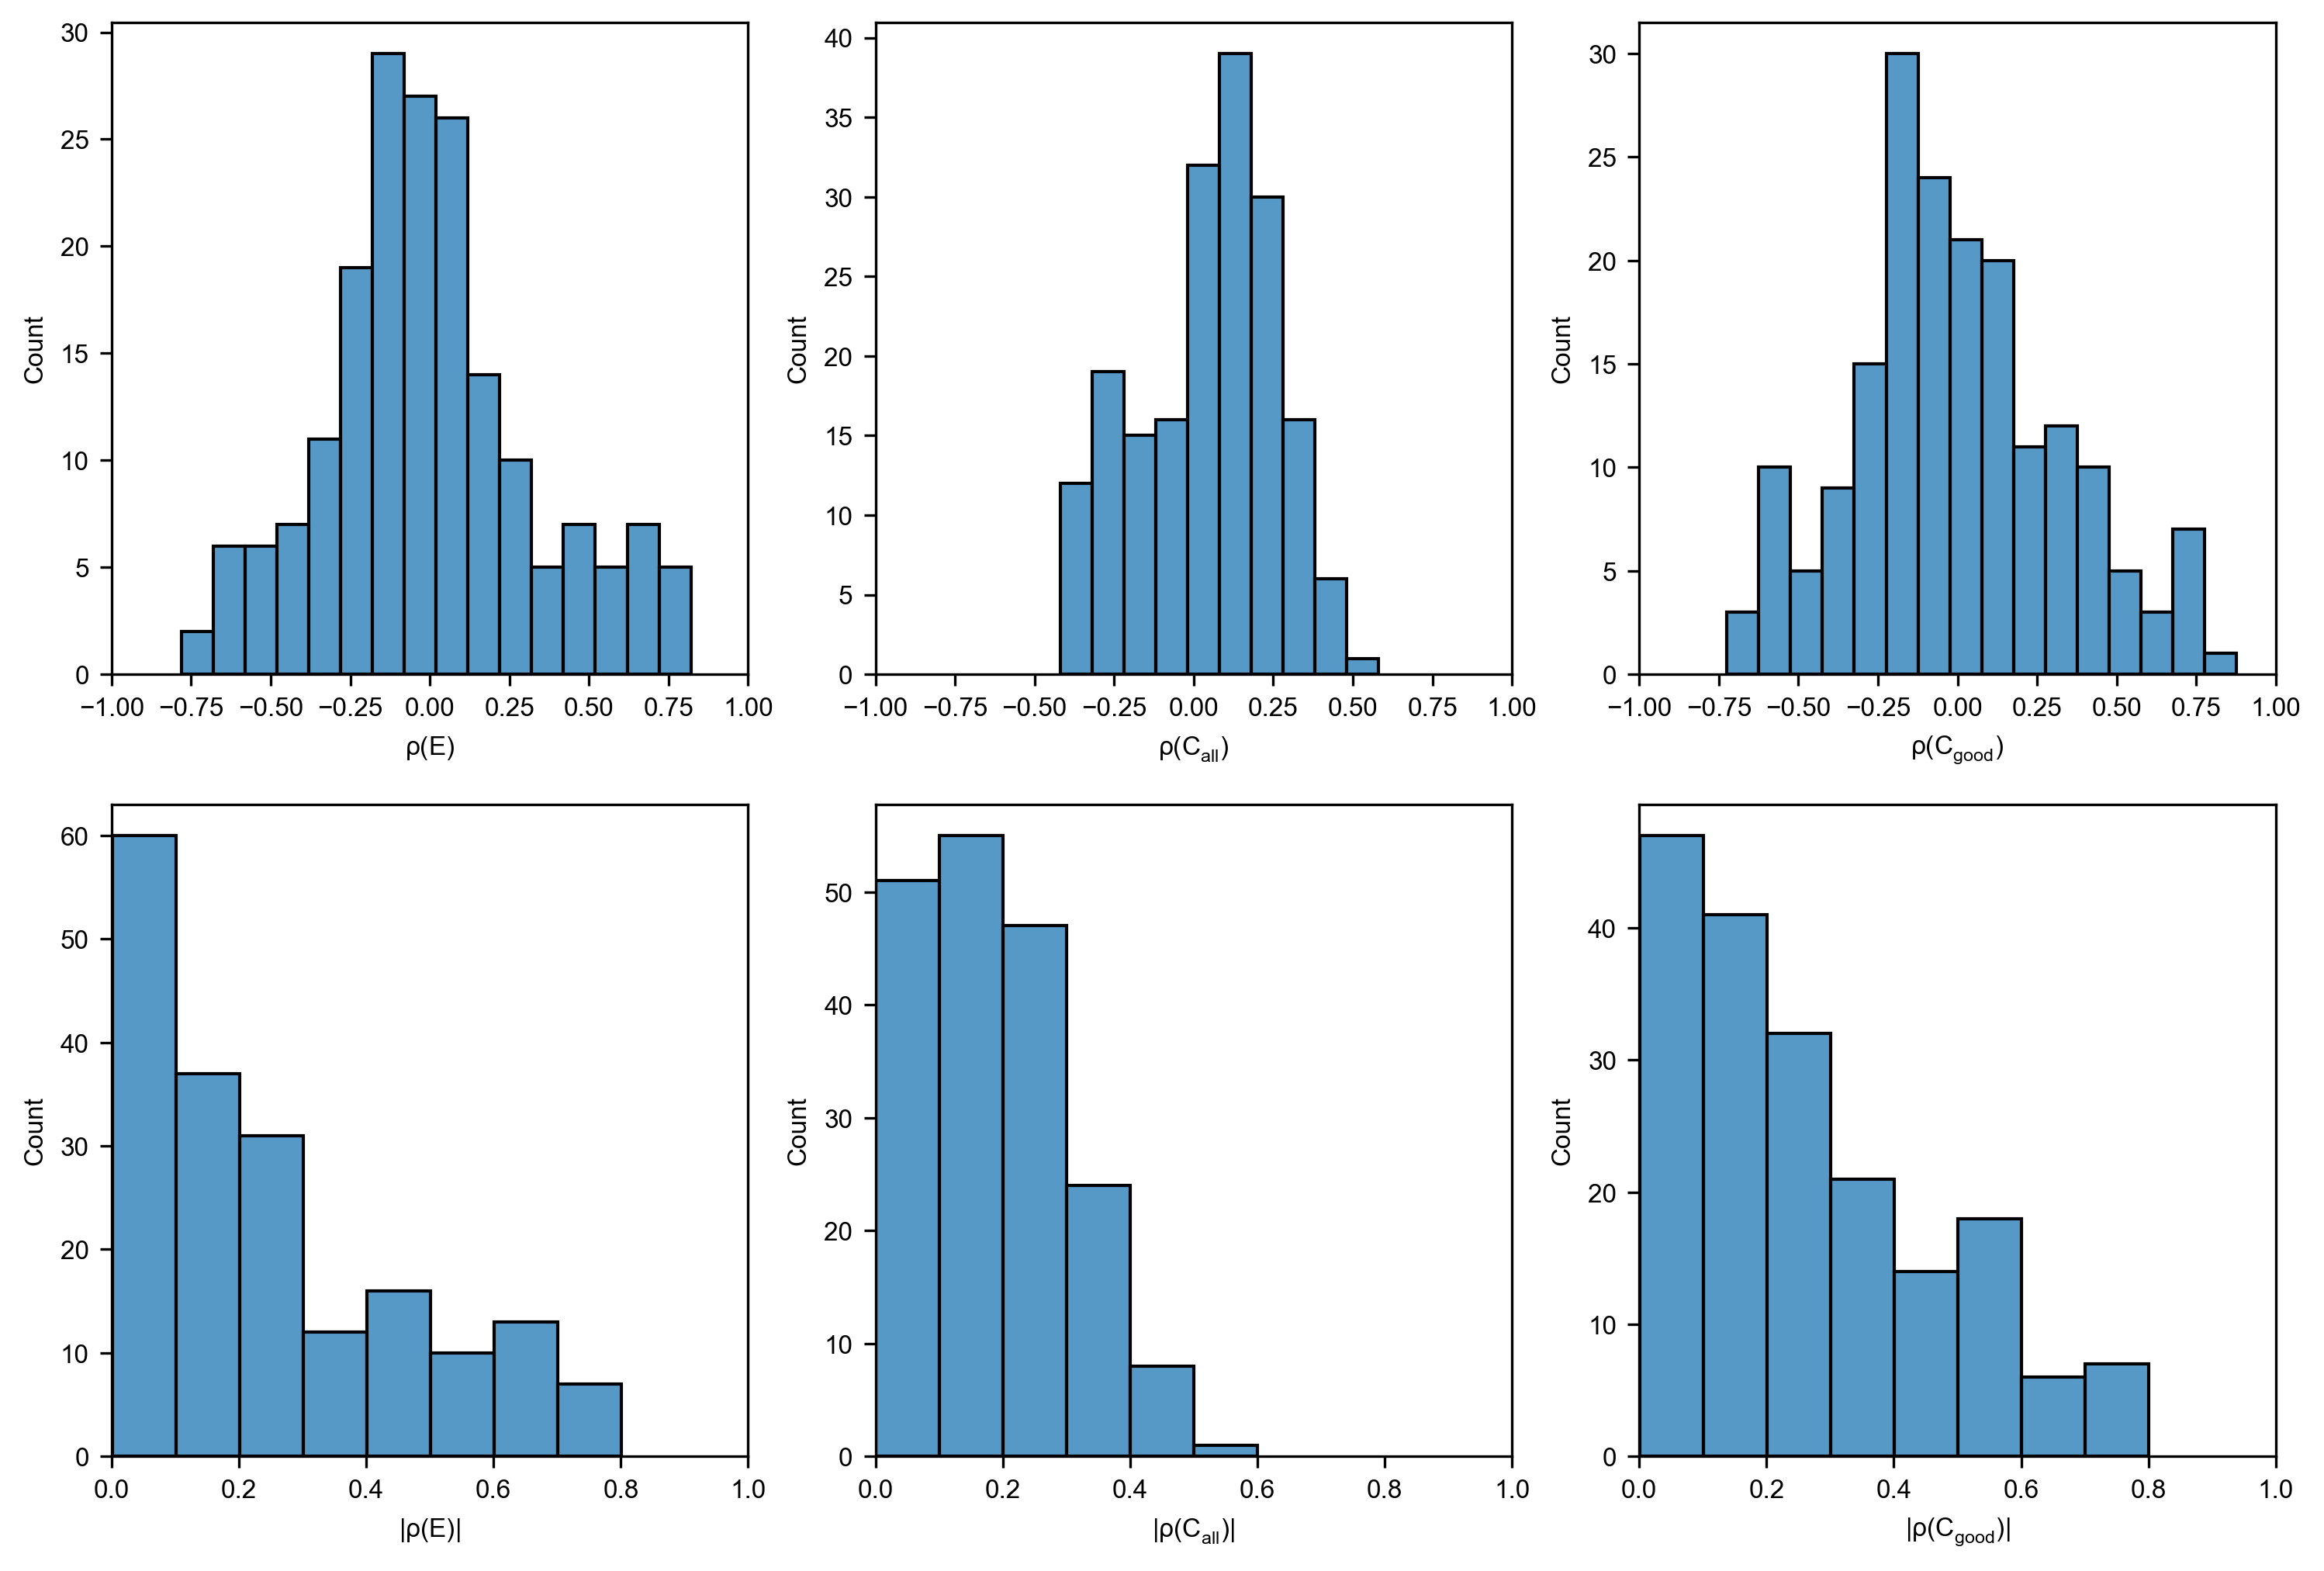

In [22]:
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows,ncols, figsize=(12,8), dpi=300)

axis_names = [[r"$\rho(E)$", r"$\rho(C_{all})$", r"$\rho(C_{good})$"],[r"$|\rho(E)|$", r"$|\rho(C_{all})|$", r"$|\rho(C_{good})|$"]]

desired_axes = ['exp_full', 'comp_full', 'comp_good', 'exp_full_abs', 'comp_full_abs', 'comp_good_abs', ]

for k, col in enumerate(desired_axes):
    i = k // ncols
    j = k % ncols
    sns.histplot(x=corr_df[col], data=corr_df, ax=ax[i][j], binwidth=0.1)
    if i == 1:
        ax[i][j].set_xlim([0, 1])
    else:
        ax[i][j].set_xlim([-1, 1])
    ax[i][j].set_xlabel(axis_names[i][j])

plt.savefig("corrhist.png", transparent=True, bbox_inches='tight')

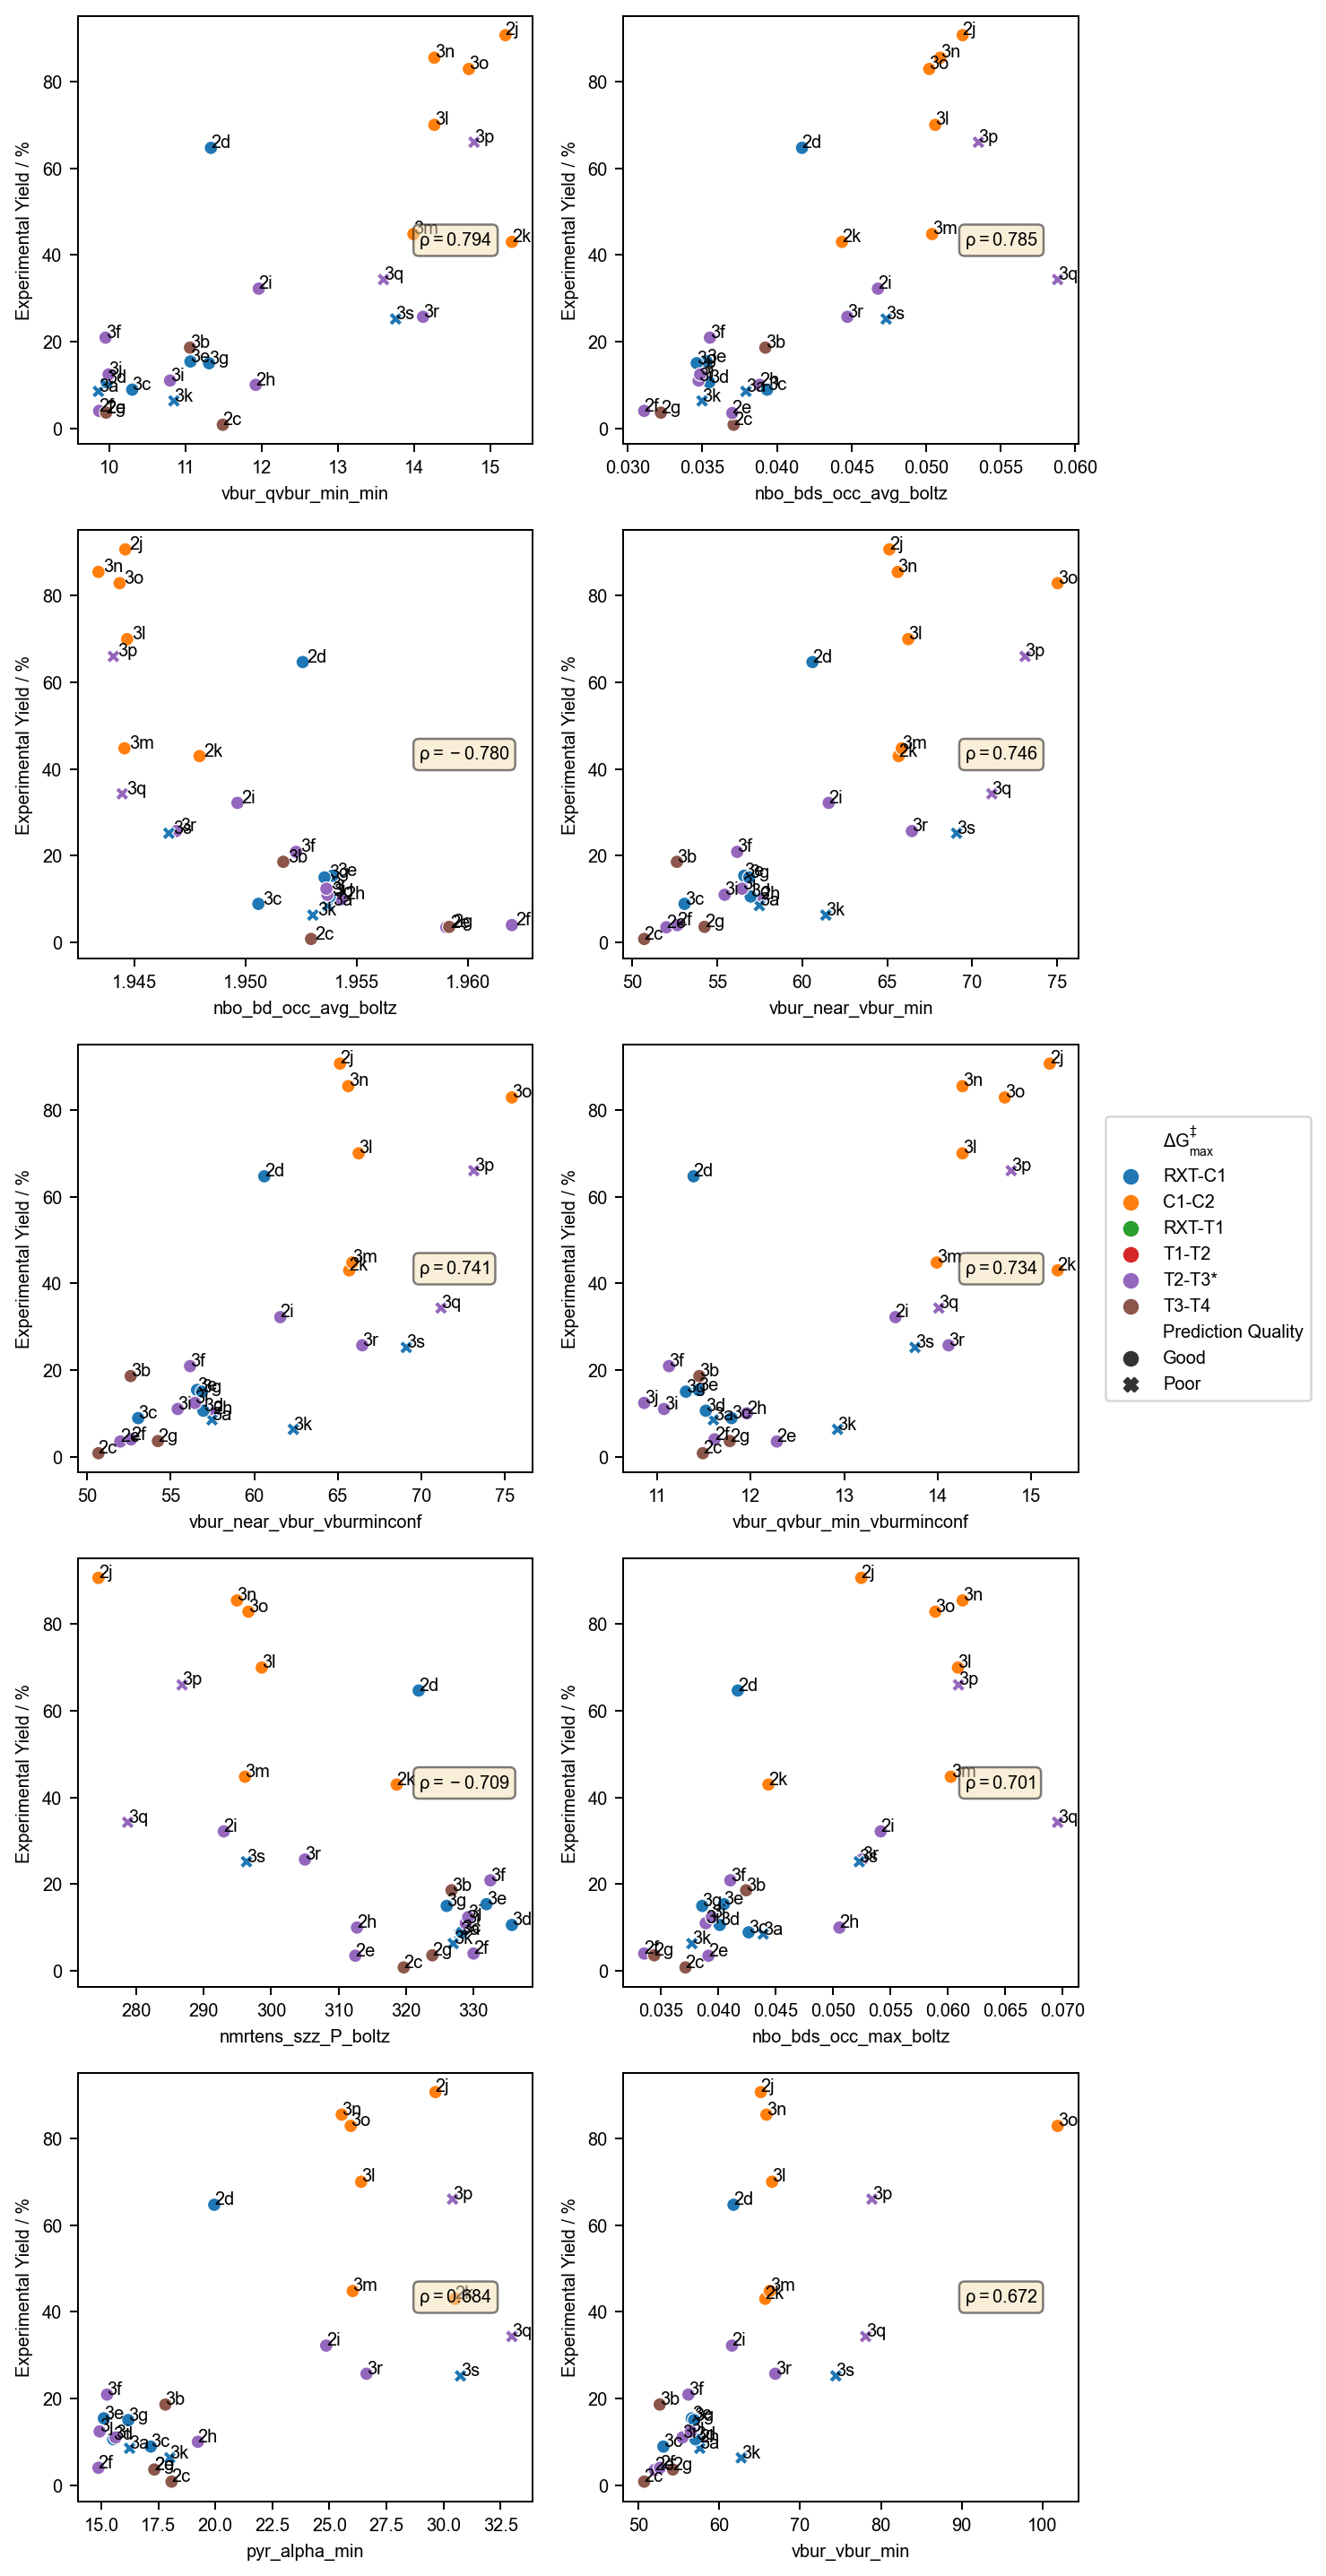

In [23]:
interest = 'exp_full'
#corr_hg[corr_hg[interest] >= 0.4].sort_values(by=interest,ascending=False)
dg = corr_df.sort_values(by='exp_full_abs_rank',ascending=True).head(10)

nrows = 5
ncols = 2

fig, ax = plt.subplots(nrows,ncols, figsize=(8,20), dpi=180)
hue_order = ['C2', 'C4', 'F2', 'F4', 'H1_eff_min', 'H3']
for n, col in enumerate(dg['descriptor']):
    i = n // ncols
    j = n % ncols
    x = col
    y = 'exp_yield'
    g = sns.scatterplot(x=x, y=y, data=hg, hue_order=hue_order, palette='tab10',style=hg['prediction_quality'], hue='max_name_eff_min', ax=ax[i][j])
    #g = sns.scatterplot(x=x, y=y, data=hg[hg['prediction_quality'] == 'Good'], hue_order=hue_order, palette='tab10',style=hg['prediction_quality'], hue='max_name', ax=ax[i][j])
    #g = sns.scatterplot(x=x, y=y, data=hg, hue_order=hue_order, palette='tab10',style=hg['prediction_quality'], hue='max_name', ax=ax[i][j])
    #for _, row in hg.iterrows():
    for _, row in hg.iterrows():
        ax[i][j].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    ax[i][j].legend_.remove()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (dg[dg['descriptor'] == col][interest]),
           transform=ax[i][j].transAxes, verticalalignment='top', bbox=props)
    ax[i][j].set_ylabel("Experimental Yield / %")


text_list = plt.legend(bbox_to_anchor=(1.04,2.9), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

#ax.set_xlabel("V$_{bur}$ (min) / %")


plt.savefig("expcorrplots.png", transparent=True, bbox_inches='tight')

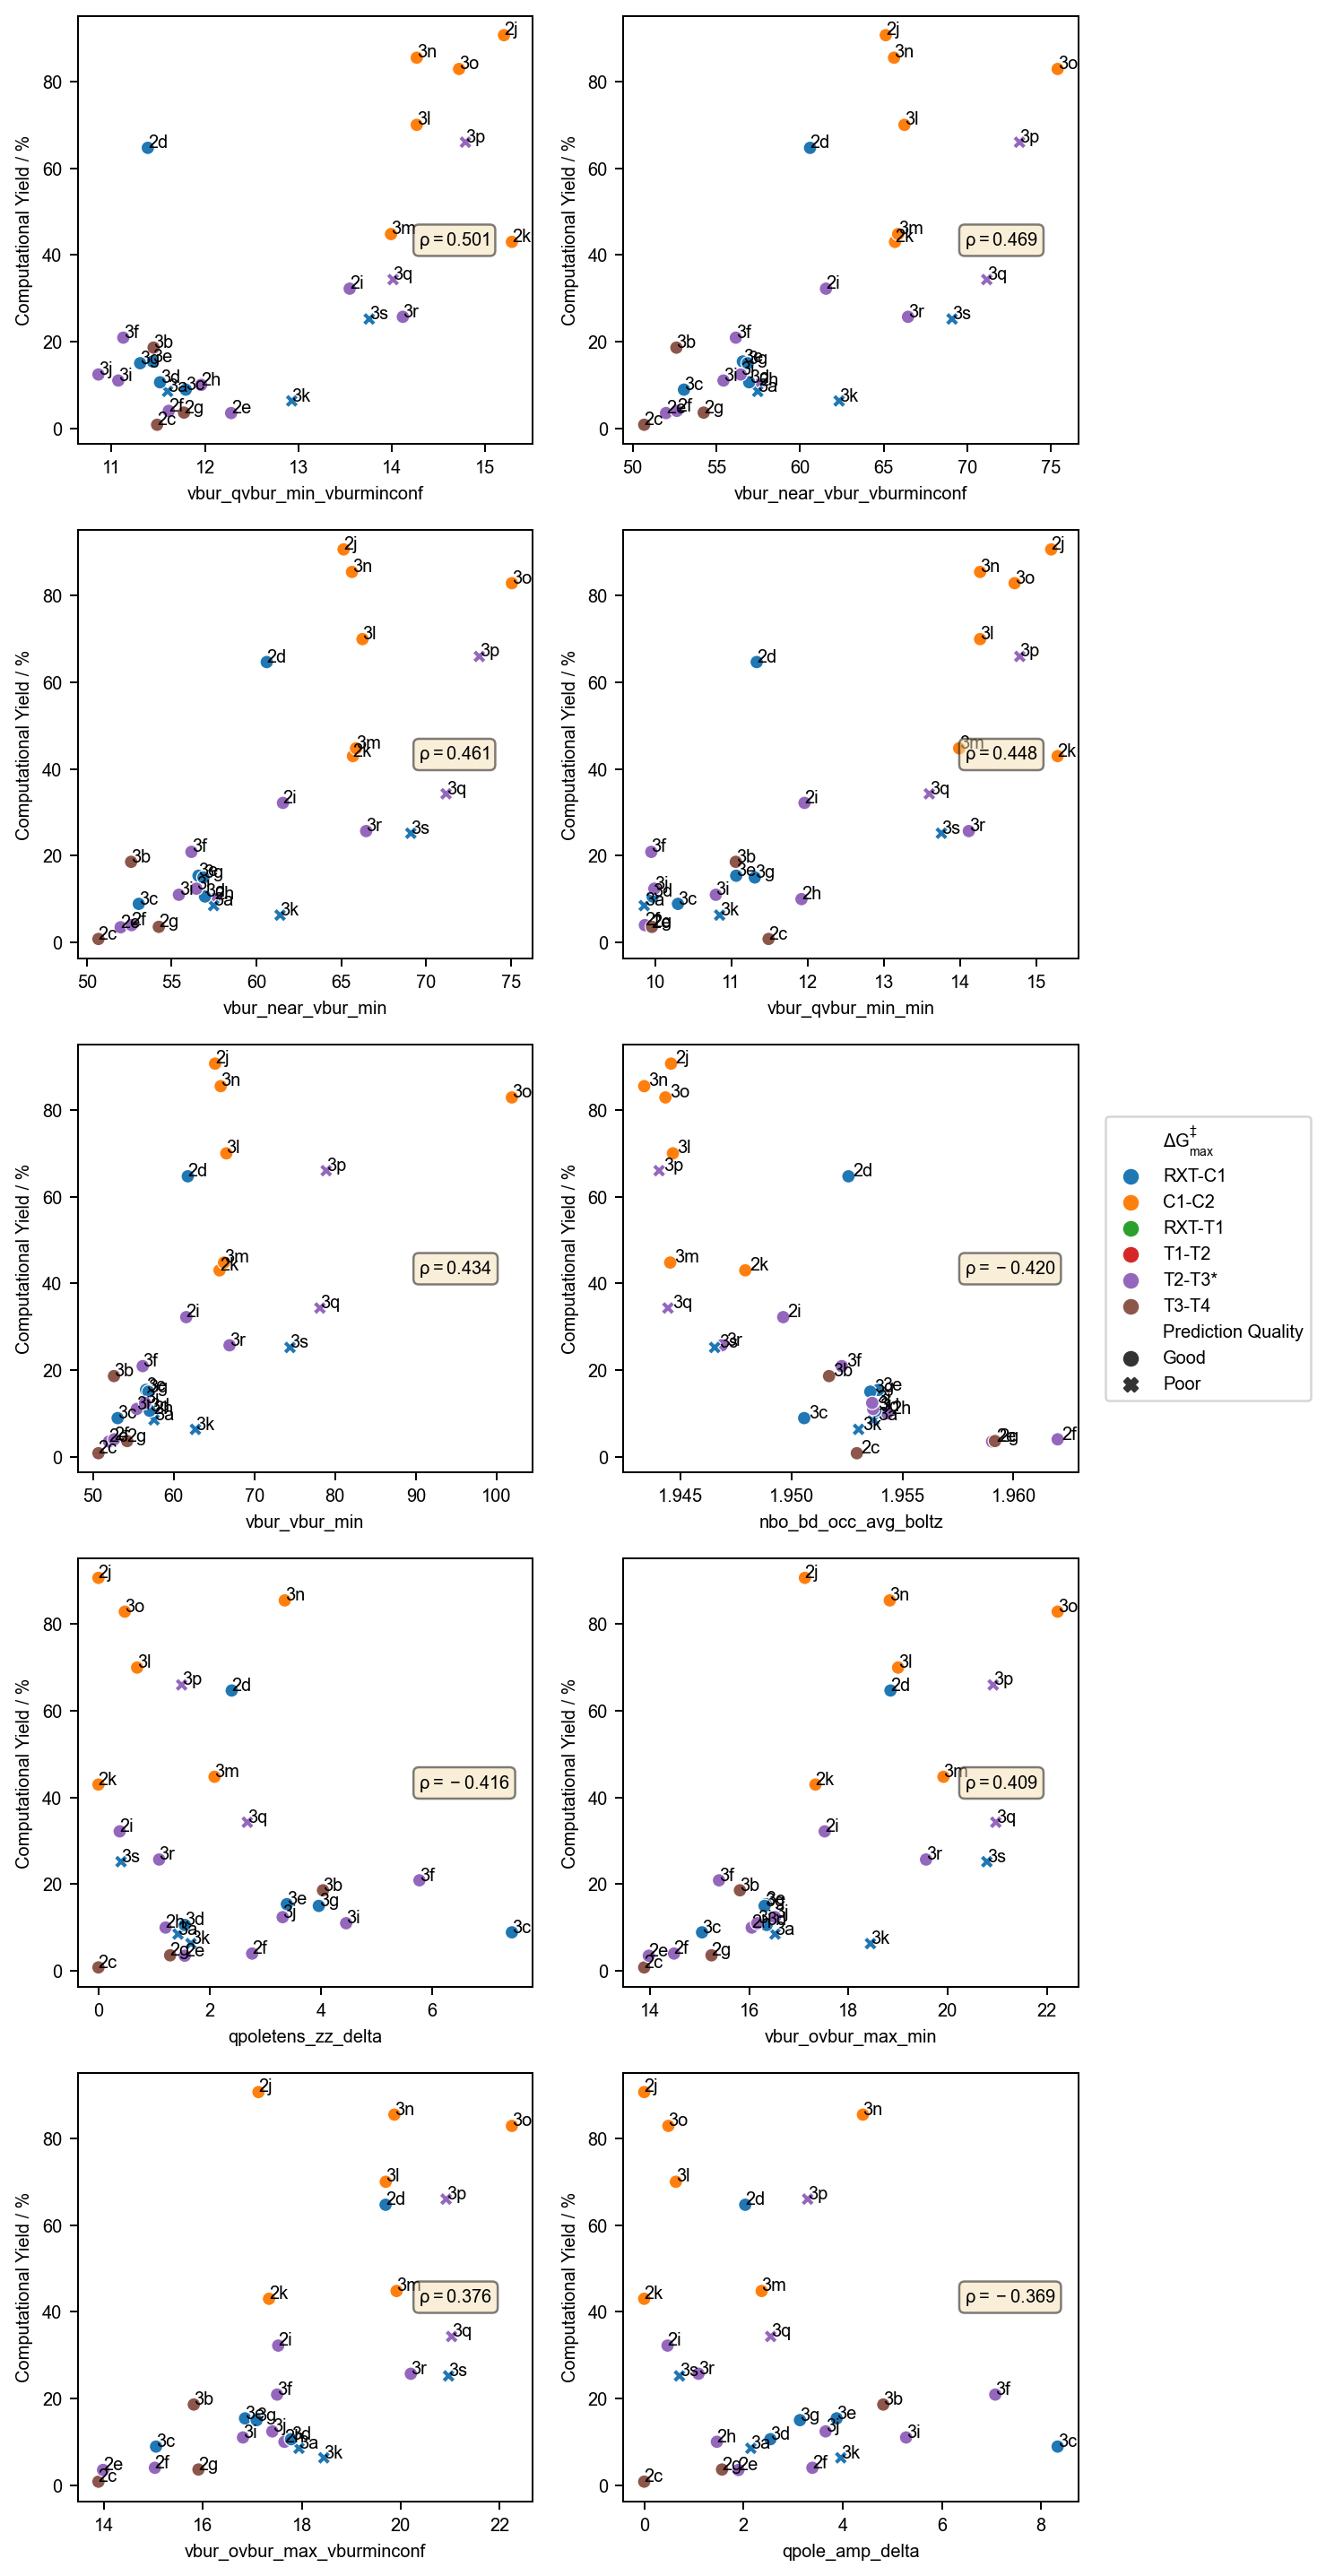

In [24]:
interest = 'comp_full'
#corr_hg[corr_hg[interest] >= 0.4].sort_values(by=interest,ascending=False)
dg = corr_df.sort_values(by='comp_full_abs_rank',ascending=True).head(15)

nrows = 5
ncols = 2

descriptor_list = ['vbur_qvbur_min_vburminconf',
 'vbur_near_vbur_vburminconf',
 'vbur_near_vbur_min',
 'vbur_qvbur_min_min',
 'vbur_vbur_min',
 'nbo_bd_occ_avg_boltz',
 'qpoletens_zz_delta',
 'vbur_ovbur_max_min',
 'vbur_ovbur_max_vburminconf',
 'qpole_amp_delta',]

fig, ax = plt.subplots(nrows,ncols, figsize=(8,20), dpi=180)
hue_order = ['C2', 'C4', 'F2', 'F4', 'H1_eff_min', 'H3']
for n, col in enumerate(descriptor_list):
    i = n // ncols
    j = n % ncols
    x = col
    y = 'exp_yield'
    g = sns.scatterplot(x=x, y=y, data=hg, hue_order=hue_order, palette='tab10',style=hg['prediction_quality'], hue='max_name_eff_min', ax=ax[i][j])
    #g = sns.scatterplot(x=x, y=y, data=hg[hg['prediction_quality'] == 'Good'], hue_order=hue_order, palette='tab10',style=hg['prediction_quality'], hue='max_name', ax=ax[i][j])
    #g = sns.scatterplot(x=x, y=y, data=hg, hue_order=hue_order, palette='tab10',style=hg['prediction_quality'], hue='max_name', ax=ax[i][j])
    #for _, row in hg.iterrows():
    for _, row in hg.iterrows():
        ax[i][j].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    ax[i][j].legend_.remove()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (dg[dg['descriptor'] == col][interest]),
           transform=ax[i][j].transAxes, verticalalignment='top', bbox=props)
    ax[i][j].set_ylabel("Computational Yield / %")


text_list = plt.legend(bbox_to_anchor=(1.04,2.9), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

#ax.set_xlabel("V$_{bur}$ (min) / %")


plt.savefig("compfullcorrplots.png", transparent=True, bbox_inches='tight')

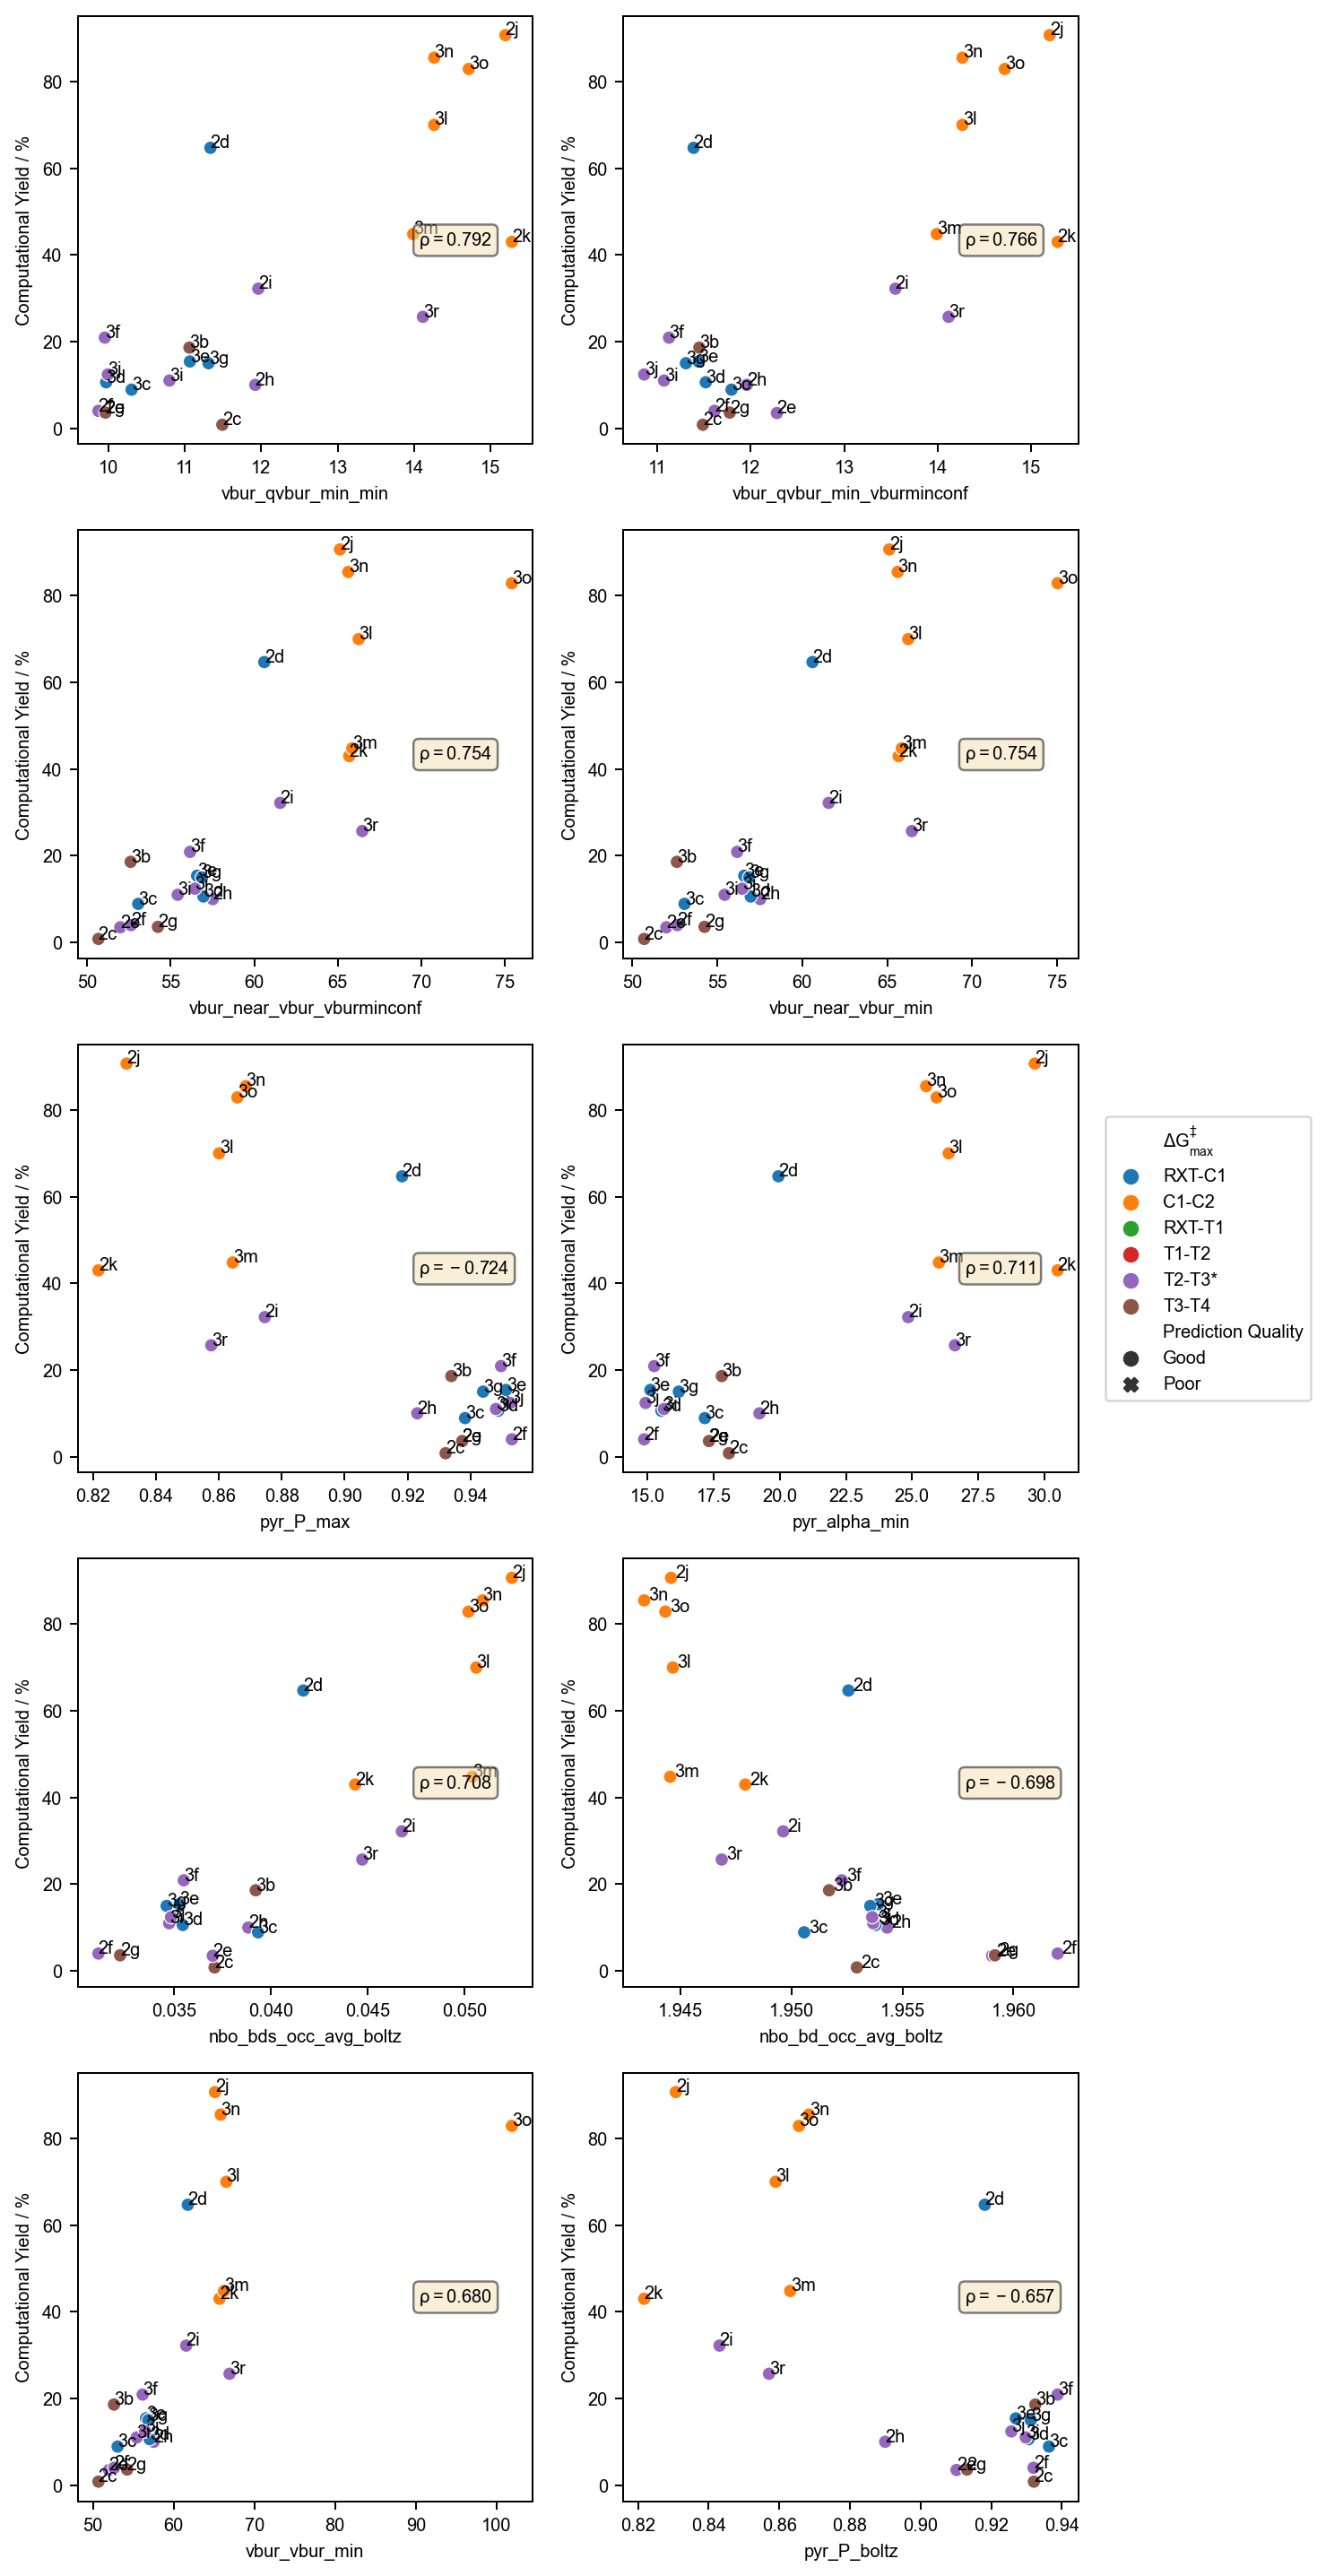

In [25]:
interest = 'comp_good'
#corr_hh[corr_hh[interest] >= 0.4].sort_values(by=interest,ascending=False)
dg = corr_df.sort_values(by='comp_good_abs_rank',ascending=True).head(15)

descriptor_list = ['vbur_qvbur_min_min',
 'vbur_qvbur_min_vburminconf',
 'vbur_near_vbur_vburminconf',
 'vbur_near_vbur_min',
 'pyr_P_max',
 'pyr_alpha_min',
 'nbo_bds_occ_avg_boltz',
 'nbo_bd_occ_avg_boltz',
 #'vbur_vbur_vburminconf',
 'vbur_vbur_min',
 'pyr_P_boltz',]

nrows = 5
ncols = 2

fig, ax = plt.subplots(nrows,ncols, figsize=(8,20), dpi=180)
hue_order = ['C2', 'C4', 'F2', 'F4', 'H1_eff_min', 'H3']
for n, col in enumerate(descriptor_list):
    i = n // ncols
    j = n % ncols
    x = col
    y = 'exp_yield'
    g = sns.scatterplot(x=x, y=y, data=hh, hue_order=hue_order, palette='tab10',style=hg['prediction_quality'], hue='max_name_eff_min', ax=ax[i][j])
    #g = sns.scatterplot(x=x, y=y, data=hh[hh['prediction_quality'] == 'Good'], hue_order=hue_order, palette='tab10',style=hh['prediction_quality'], hue='max_name', ax=ax[i][j])
    #g = sns.scatterplot(x=x, y=y, data=hh, hue_order=hue_order, palette='tab10',style=hh['prediction_quality'], hue='max_name', ax=ax[i][j])
    #for _, row in hh.iterrows():
    for _, row in hh.iterrows():
        ax[i][j].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    ax[i][j].legend_.remove()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (dg[dg['descriptor'] == col][interest]),
           transform=ax[i][j].transAxes, verticalalignment='top', bbox=props)
    ax[i][j].set_ylabel("Computational Yield / %")


text_list = plt.legend(bbox_to_anchor=(1.04,2.9), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

#ax.set_xlabel("V$_{bur}$ (min) / %")


plt.savefig("compgoodcorrplots.png", transparent=True, bbox_inches='tight')